In [2]:
!pip install tensorflow==1.12

  Using cached tensorflow-1.12.0-cp36-cp36m-manylinux1_x86_64.whl (83.1 MB)
  Using cached tensorboard-1.12.2-py3-none-any.whl (3.0 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-serving-api 1.15.0 requires tensorflow~=1.15.0, but you have tensorflow 1.12.0 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/bin/python -m pip install --upgrade pip' command.


# Importing Libraries

In [3]:
import pandas as pd
import nested_function as nf
import numpy as np
from math import degrees,sqrt,atan
import cv2

### Reading in 'Below_6.0_SAO.csv and putting the data into a list to be processed

In [5]:
col_list = ["Star ID","RA","DE","Magnitude"]
catalogue = pd.read_csv('Below_4.0_SAO.csv',usecols=col_list)

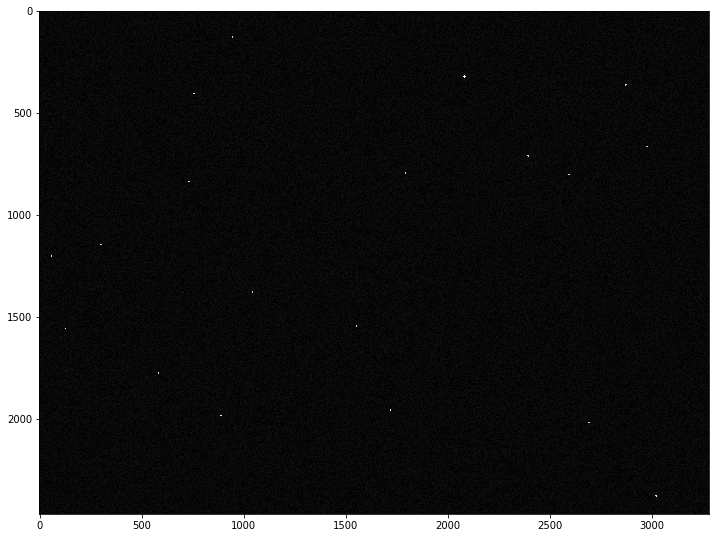

In [7]:
image = nf.create_star_image(1,0,0,catalogue)
nf.displayImg(image)

# Creating Datasets
The datasets that are going to be created are 3 for the training which is:
- 1 degree bin increment
- 2 degree bin increment
- 3 degree bin increment
- 4 degree bin increment

### Defining the function to extract features from 'Below_6.0_SAO.csv

In [8]:
#Extract features function
def extract_rb_features(bin_increment,image,myu,f):
    """[This function extracts the radial basis features from a given star image and returns the bin feature vectors]

    Args:
        bin_increment ([int]): [The bin increment is the delta theta for the histogram of features (IN DEGREES)]
        image ([numpy array]): [The star image]
        myu ([float]): [length per pixel]
        f ([float]): [focal length]
    """
    #Defining some reusable variables to use
    half_length_pixel = image.shape[1]/2
    half_width_pixel = image.shape[0]/2
    FOVy_half = degrees(atan((half_width_pixel*myu)/f))

    #Initializing the bin list
    length_of_bin = FOVy_half//bin_increment
    bin_list = [0] * int(length_of_bin)

    #Get all the centroids
    image = image.astype('uint8')
    params = cv2.SimpleBlobDetector_Params()
    params.filterByInertia = False
    params.filterByConvexity = False
    params.minThreshold = 50
    params.maxThreshold = 255
    params.filterByColor = True
    params.blobColor = 255
    params.filterByArea = False
    params.minArea = 1
    detector = cv2.SimpleBlobDetector_create(params)

    keypoints = detector.detect(image)
    #Iterating through all the stars present
    for index,keypoint in enumerate(keypoints):
        x_centralstar = int(round(keypoints[index].pt[0]))
        y_centralstar = int(round(keypoints[index].pt[1]))
        #Converting to origin-in-the-middle coordinates
        x = x_centralstar - half_length_pixel
        y = half_width_pixel - y_centralstar
        pixel_distance_to_center = sqrt((x**2)+(y**2))
        angular_distance_to_center = round(degrees(atan((pixel_distance_to_center*myu)/f)),3)
        if angular_distance_to_center > FOVy_half:
            continue
        lower_bound = 0
        upper_bound = bin_increment
        bin_index = 0
        #Evaluate which bin is this star in
        while upper_bound <= FOVy_half:
            if lower_bound <= angular_distance_to_center < upper_bound:
                bin_list[bin_index] += 1
            lower_bound += bin_increment
            upper_bound += bin_increment
            bin_index += 1

    return bin_list

### Initializing the feature vector data structure to store dataset
(Stored in map data structure to extract columns easier)
- 1 Bin Increment -> 24 feature vectors
- 2 Bin Increment -> 12 feature vectors
- 3 Bin Increment -> 8 feature vectors
- 4 Bin Increment -> 6 feature vectors

In [9]:
class getFeatureVectorDataStructure():
    #Feature vector data structure for 1 bin increment
    bin_increment_one = {
        'Star ID' : [],
        'Bin 1'   : [],
        'Bin 2'   : [],
        'Bin 3'   : [],
        'Bin 4'   : [],
        'Bin 5'   : [],
        'Bin 6'   : [],
        'Bin 7'   : [],
        'Bin 8'   : [],
        'Bin 9'   : [],
        'Bin 10'  : [],
        'Bin 11'  : [],
        'Bin 12'  : [],
        'Bin 13'  : [],
        'Bin 14'  : [],
        'Bin 15'  : [],
        'Bin 16'  : [],
        'Bin 17'  : [],
        'Bin 18'  : [],
        'Bin 19'  : [],
        'Bin 20'  : [],
        'Bin 21'  : [],
        'Bin 22'  : [],
        'Bin 23'  : [],
        'Bin 24'  : []
    }
    bin_increment_two = {
        'Star ID' : [],
        'Bin 1'   : [],
        'Bin 2'   : [],
        'Bin 3'   : [],
        'Bin 4'   : [],
        'Bin 5'   : [],
        'Bin 6'   : [],
        'Bin 7'   : [],
        'Bin 8'   : [],
        'Bin 9'   : [],
        'Bin 10'  : [],
        'Bin 11'  : [],
        'Bin 12'  : []
    }
    bin_increment_three = {
        'Star ID' : [],
        'Bin 1'   : [],
        'Bin 2'   : [],
        'Bin 3'   : [],
        'Bin 4'   : [],
        'Bin 5'   : [],
        'Bin 6'   : [],
        'Bin 7'   : [],
        'Bin 8'   : []
    }
    bin_increment_four = {
        'Star ID' : [],
        'Bin 1'   : [],
        'Bin 2'   : [],
        'Bin 3'   : [],
        'Bin 4'   : [],
        'Bin 5'   : [],
        'Bin 6'   : []
}

### Creating the dataset
There are going to be 4 datasets for each of the bin increment. So we have a total of 12 datasets

In [10]:
#Initialize camera properties
MYU = 1.12*(10**-6)
F = 0.00304

In [11]:
class getColumns():
    bin_increment_one = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8','Bin 9','Bin 10','Bin 11','Bin 12','Bin 13','Bin 14','Bin 15','Bin 16','Bin 17','Bin 18','Bin 19','Bin 20','Bin 21','Bin 22','Bin 23','Bin 24']
    bin_increment_two = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8','Bin 9','Bin 10','Bin 11','Bin 12']
    bin_increment_three = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8']
    bin_increment_four = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6']

In [12]:
#Function to create dataset
def create_dataset(bin_increment,missing_and_unexpected,catalogue,feature_vector_datastructure,columns,myu=MYU,f=F):
    
    #Instantiate lists
    ra_list = list(catalogue['RA'])
    de_list = list(catalogue['DE'])
    star_id_list = list(catalogue['Star ID'])
    
    #Iterating through all stars
    for i in range(len(star_id_list)):
        print("STAR {0} of {1}".format(i+1,len(star_id_list)))
        star_id = star_id_list[i]
        ra = degrees(ra_list[i])
        de = degrees(de_list[i])
        
        #Roll angle with increment of 24
        for roll in range(0,360,24):
            image = nf.create_star_image(ra,de,roll,catalogue,missing_and_unexpected,missing_and_unexpected)
            features = extract_rb_features(bin_increment=bin_increment,image=image,myu=myu,f=f)
            feature_vector_datastructure['Star ID'].append(star_id)
            
            #Appending features to data structure
            for bin_number in range(len(features)):
                column_name = "Bin {0}".format(bin_number+1)
                feature_vector_datastructure[column_name].append(features[bin_number])
                
    feature_vector_dataframe = pd.DataFrame(
    feature_vector_datastructure,
    columns=columns)
    return feature_vector_dataframe

In [49]:
import random

def getRows(csv_path):
    df = pd.read_csv(csv_path)
    return len(df)

def getIndices():
    total = 7200
    test_indices = []
    train_indices = []
    for i in range(total):
        #i = 0,1,2,3,4,5
        if ((i+1)%5==0):
            test_indices.append(i)
        else:
            train_indices.append(i)
    return test_indices,train_indices

# 1. Bin Increment of 1
Cases:
- 0 star missing and unexpected
- 2 star missing and unexpected
- 4 star missing and unexpected
- 6 star missing and unexpected

## First Case: 0 star missing and unexpected with 80/20 train test ratio

In [14]:
print(getFeatureVectorDataStructure().bin_increment_one)

{'Star ID': [], 'Bin 1': [], 'Bin 2': [], 'Bin 3': [], 'Bin 4': [], 'Bin 5': [], 'Bin 6': [], 'Bin 7': [], 'Bin 8': [], 'Bin 9': [], 'Bin 10': [], 'Bin 11': [], 'Bin 12': [], 'Bin 13': [], 'Bin 14': [], 'Bin 15': [], 'Bin 16': [], 'Bin 17': [], 'Bin 18': [], 'Bin 19': [], 'Bin 20': [], 'Bin 21': [], 'Bin 22': [], 'Bin 23': [], 'Bin 24': []}


In [15]:
print(getColumns().bin_increment_one)

['Star ID', 'Bin 1', 'Bin 2', 'Bin 3', 'Bin 4', 'Bin 5', 'Bin 6', 'Bin 7', 'Bin 8', 'Bin 9', 'Bin 10', 'Bin 11', 'Bin 12', 'Bin 13', 'Bin 14', 'Bin 15', 'Bin 16', 'Bin 17', 'Bin 18', 'Bin 19', 'Bin 20', 'Bin 21', 'Bin 22', 'Bin 23', 'Bin 24']


In [16]:
#0 star missing and unexpected
bin_increment = 1
missing_and_unexpected = 0
columns = getColumns().bin_increment_one
feature_vector_datastructure = getFeatureVectorDataStructure().bin_increment_one

#Calling function
feature_vector_dataframe_bin_1_0_missingandunexpected = create_dataset(bin_increment,missing_and_unexpected,catalogue,feature_vector_datastructure,columns)

#Saving dataset
feature_vector_dataframe_bin_1_0_missingandunexpected.to_csv('BinIncrement_One/bin_1_miss_unexpected_0.csv',index=False)

STAR 1 of 480
STAR 2 of 480
STAR 3 of 480
STAR 4 of 480
STAR 5 of 480
STAR 6 of 480
STAR 7 of 480
STAR 8 of 480
STAR 9 of 480
STAR 10 of 480
STAR 11 of 480
STAR 12 of 480
STAR 13 of 480
STAR 14 of 480
STAR 15 of 480
STAR 16 of 480
STAR 17 of 480
STAR 18 of 480
STAR 19 of 480
STAR 20 of 480
STAR 21 of 480
STAR 22 of 480
STAR 23 of 480
STAR 24 of 480
STAR 25 of 480
STAR 26 of 480
STAR 27 of 480
STAR 28 of 480
STAR 29 of 480
STAR 30 of 480
STAR 31 of 480
STAR 32 of 480
STAR 33 of 480
STAR 34 of 480
STAR 35 of 480
STAR 36 of 480
STAR 37 of 480
STAR 38 of 480
STAR 39 of 480
STAR 40 of 480
STAR 41 of 480
STAR 42 of 480
STAR 43 of 480
STAR 44 of 480
STAR 45 of 480
STAR 46 of 480
STAR 47 of 480
STAR 48 of 480
STAR 49 of 480
STAR 50 of 480
STAR 51 of 480
STAR 52 of 480
STAR 53 of 480
STAR 54 of 480
STAR 55 of 480
STAR 56 of 480
STAR 57 of 480
STAR 58 of 480
STAR 59 of 480
STAR 60 of 480
STAR 61 of 480
STAR 62 of 480
STAR 63 of 480
STAR 64 of 480
STAR 65 of 480
STAR 66 of 480
STAR 67 of 480
STAR

In [51]:
#SPLIT
#Bin increment 1, missing and unexpected 0 20% test
csv_path = 'BinIncrement_One/bin_1_miss_unexpected_0.csv'
data_np = pd.read_csv(csv_path).to_numpy()
rows = getRows(csv_path)
test_index,train_index = getIndices()

test_data = []
train_data = []
for test_i in test_index:
    print(test_i)
    test_data.append(data_np[test_i])
for train_i in train_index:
    train_data.append(data_np[train_i])
test_data = np.array(test_data)
train_data = np.array(train_data)

column_values = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8','Bin 9','Bin 10','Bin 11','Bin 12','Bin 13','Bin 14','Bin 15','Bin 16','Bin 17','Bin 18','Bin 19','Bin 20','Bin 21','Bin 22','Bin 23','Bin 24']
df_test = pd.DataFrame(data=test_data,columns=column_values)
df_test.to_csv('BinIncrement_One/_0_missing_unexpected/20_test/test.csv')
df_train = pd.DataFrame(data=train_data,columns=column_values)
df_train.to_csv('BinIncrement_One/_0_missing_unexpected/20_test/train.csv')

4
9
14
19
24
29
34
39
44
49
54
59
64
69
74
79
84
89
94
99
104
109
114
119
124
129
134
139
144
149
154
159
164
169
174
179
184
189
194
199
204
209
214
219
224
229
234
239
244
249
254
259
264
269
274
279
284
289
294
299
304
309
314
319
324
329
334
339
344
349
354
359
364
369
374
379
384
389
394
399
404
409
414
419
424
429
434
439
444
449
454
459
464
469
474
479
484
489
494
499
504
509
514
519
524
529
534
539
544
549
554
559
564
569
574
579
584
589
594
599
604
609
614
619
624
629
634
639
644
649
654
659
664
669
674
679
684
689
694
699
704
709
714
719
724
729
734
739
744
749
754
759
764
769
774
779
784
789
794
799
804
809
814
819
824
829
834
839
844
849
854
859
864
869
874
879
884
889
894
899
904
909
914
919
924
929
934
939
944
949
954
959
964
969
974
979
984
989
994
999
1004
1009
1014
1019
1024
1029
1034
1039
1044
1049
1054
1059
1064
1069
1074
1079
1084
1089
1094
1099
1104
1109
1114
1119
1124
1129
1134
1139
1144
1149
1154
1159
1164
1169
1174
1179
1184
1189
1194
1199
1204
1209
1214
1219
12

In [52]:
# Bin increment 1, 0 missing unexpected 20% test
#Importing the data set
train_dataset = pd.read_csv('BinIncrement_One/_0_missing_unexpected/20_test/train.csv').to_numpy()[1:,1:]
x_train = train_dataset[:,1:]
y_train = train_dataset[:,0]


#Normalize the data
x_train = x_train/x_train.max()

#Convert the y_train to be one-hot encoded because they're not a regression problem, to do categorical analysis by Keras.
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.reshape(-1,1))
y_cat_train = enc.transform(y_train.reshape(-1,1)).toarray()

#BUILDING THE MODEL
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(24,activation='relu',input_shape=(x_train.shape[1],)))
model.add(Dense(units=48,activation='relu'))
model.add(Dense(units=96,activation='relu'))
model.add(Dense(units=192,activation='relu'))
model.add(Dense(units=384,activation='relu'))
model.add(Dense(units=420,activation='relu'))
model.add(Dense(units=450,activation='relu'))
model.add(Dense(480,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
print(model.summary())

#TRAINING THE MODEL
model.fit(x_train,y_cat_train,epochs=25)

#SAVING THE MODEL
model.save('BinIncrement_One/_0_missing_unexpected/20_test/model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_10 (Dense)             (None, 48)                1200      
_________________________________________________________________
dense_11 (Dense)             (None, 96)                4704      
_________________________________________________________________
dense_12 (Dense)             (None, 192)               18624     
_________________________________________________________________
dense_13 (Dense)             (None, 384)               74112     
_________________________________________________________________
dense_14 (Dense)             (None, 420)               161700    
_________________________________________________________________
dense_15 (Dense)             (None, 450)               189450    
__________

In [53]:
#Testing
#bin 1 miss 0 test 25
from keras.models import load_model
myModel = load_model('BinIncrement_One/_0_missing_unexpected/20_test/model.h5')
testData = pd.read_csv('BinIncrement_One/_0_missing_unexpected/20_test/test.csv').to_numpy()
x_test = testData[:,2:]
x_test = x_test/x_test.max()
y_test = testData[:,1]

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_test.reshape(-1,1))
y_cat_test = enc.transform(y_test.reshape(-1,1)).toarray()

from sklearn.metrics import classification_report
predictions = myModel.predict_classes(x_test) #The predictions are not in one-hot encoded

predictions = list(predictions)

print(predictions)

[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 29, 29, 29, 30, 30, 30, 31, 31, 31, 225, 225, 225, 33, 33, 33, 34, 34, 34, 34, 34, 34, 36, 36, 36, 37, 37, 37, 38, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 42, 43, 43, 43, 44, 44, 44, 45, 45, 45, 46, 46, 46, 47, 47, 47, 48, 48, 48, 49, 49, 49, 50, 50, 50, 51, 51, 51, 52, 52, 52, 53, 53, 53, 54, 54, 54, 55, 55, 55, 56, 56, 56, 57, 57, 57, 58, 58, 58, 59, 59, 59, 60, 60, 60, 61, 61, 61, 62, 62, 62, 63, 63, 63, 64, 64, 64, 65, 65, 65, 66, 66, 66, 67, 67, 67, 68, 68, 68, 69, 69, 69, 70, 70, 70, 71, 71, 71, 72, 72, 72, 73, 73, 73, 74, 74, 74, 75, 75, 75, 76, 76, 76, 77, 77, 77, 78, 78, 78, 79, 79, 79, 269, 80, 80, 81, 81, 81, 82, 82, 82, 83, 83, 83, 84, 84, 84, 85, 8

In [55]:
new_y_test = list(y_test)
counter = -1
comparator = -1
simpan = []
for element in new_y_test:
    if (element!=comparator):
        comparator = element
        counter += 1
    simpan.append(counter)

print(simpan)

[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 29, 29, 29, 30, 30, 30, 31, 31, 31, 32, 32, 32, 33, 33, 33, 34, 34, 34, 35, 35, 35, 36, 36, 36, 37, 37, 37, 38, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 42, 43, 43, 43, 44, 44, 44, 45, 45, 45, 46, 46, 46, 47, 47, 47, 48, 48, 48, 49, 49, 49, 50, 50, 50, 51, 51, 51, 52, 52, 52, 53, 53, 53, 54, 54, 54, 55, 55, 55, 56, 56, 56, 57, 57, 57, 58, 58, 58, 59, 59, 59, 60, 60, 60, 61, 61, 61, 62, 62, 62, 63, 63, 63, 64, 64, 64, 65, 65, 65, 66, 66, 66, 67, 67, 67, 68, 68, 68, 69, 69, 69, 70, 70, 70, 71, 71, 71, 72, 72, 72, 73, 73, 73, 74, 74, 74, 75, 75, 75, 76, 76, 76, 77, 77, 77, 78, 78, 78, 79, 79, 79, 80, 80, 80, 81, 81, 81, 82, 82, 82, 83, 83, 83, 84, 84, 84, 85, 85, 8

In [63]:
right = 0
wrong = 0
for i in range(len(simpan)):
    prediction = predictions[i]
    actual = simpan[i]
    if (prediction==actual):
        right += 1
    else:
        wrong += 1
        
accuracy = right/(right+wrong)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.98125


## Second Case: 2 star missing and unexpected with 80/20 train test ratio

In [64]:
bin_increment_one_ds = {
        'Star ID' : [],
        'Bin 1'   : [],
        'Bin 2'   : [],
        'Bin 3'   : [],
        'Bin 4'   : [],
        'Bin 5'   : [],
        'Bin 6'   : [],
        'Bin 7'   : [],
        'Bin 8'   : [],
        'Bin 9'   : [],
        'Bin 10'  : [],
        'Bin 11'  : [],
        'Bin 12'  : [],
        'Bin 13'  : [],
        'Bin 14'  : [],
        'Bin 15'  : [],
        'Bin 16'  : [],
        'Bin 17'  : [],
        'Bin 18'  : [],
        'Bin 19'  : [],
        'Bin 20'  : [],
        'Bin 21'  : [],
        'Bin 22'  : [],
        'Bin 23'  : [],
        'Bin 24'  : []
    }

In [65]:
bin_increment_one_columns = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8','Bin 9','Bin 10','Bin 11','Bin 12','Bin 13','Bin 14','Bin 15','Bin 16','Bin 17','Bin 18','Bin 19','Bin 20','Bin 21','Bin 22','Bin 23','Bin 24']

In [66]:
#2 star missing and unexpected
bin_increment = 1
missing_and_unexpected = 2
columns = bin_increment_one_columns
feature_vector_datastructure = bin_increment_one_ds

#Calling function
feature_vector_dataframe_bin_1_2_missingandunexpected = create_dataset(bin_increment,missing_and_unexpected,catalogue,feature_vector_datastructure,columns)

#Saving dataset
feature_vector_dataframe_bin_1_2_missingandunexpected.to_csv('BinIncrement_One/bin_1_miss_unexpected_2.csv',index=False)

STAR 1 of 480
STAR 2 of 480
STAR 3 of 480
STAR 4 of 480
STAR 5 of 480
STAR 6 of 480
STAR 7 of 480
STAR 8 of 480
STAR 9 of 480
STAR 10 of 480
STAR 11 of 480
STAR 12 of 480
STAR 13 of 480
STAR 14 of 480
STAR 15 of 480
STAR 16 of 480
STAR 17 of 480
STAR 18 of 480
STAR 19 of 480
STAR 20 of 480
STAR 21 of 480
STAR 22 of 480
STAR 23 of 480
STAR 24 of 480
STAR 25 of 480
STAR 26 of 480
STAR 27 of 480
STAR 28 of 480
STAR 29 of 480
STAR 30 of 480
STAR 31 of 480
STAR 32 of 480
STAR 33 of 480
STAR 34 of 480
STAR 35 of 480
STAR 36 of 480
STAR 37 of 480
STAR 38 of 480
STAR 39 of 480
STAR 40 of 480
STAR 41 of 480
STAR 42 of 480
STAR 43 of 480
STAR 44 of 480
STAR 45 of 480
STAR 46 of 480
STAR 47 of 480
STAR 48 of 480
STAR 49 of 480
STAR 50 of 480
STAR 51 of 480
STAR 52 of 480
STAR 53 of 480
STAR 54 of 480
STAR 55 of 480
STAR 56 of 480
STAR 57 of 480
STAR 58 of 480
STAR 59 of 480
STAR 60 of 480
STAR 61 of 480
STAR 62 of 480
STAR 63 of 480
STAR 64 of 480
STAR 65 of 480
STAR 66 of 480
STAR 67 of 480
STAR

In [68]:
#SPLIT
#Bin increment 1, missing and unexpected 0 20% test
csv_path = 'BinIncrement_One/bin_1_miss_unexpected_2.csv'
data_np = pd.read_csv(csv_path).to_numpy()
rows = getRows(csv_path)
test_index,train_index = getIndices()

test_data = []
train_data = []
for test_i in test_index:
    test_data.append(data_np[test_i])
for train_i in train_index:
    train_data.append(data_np[train_i])
test_data = np.array(test_data)
train_data = np.array(train_data)

column_values = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8','Bin 9','Bin 10','Bin 11','Bin 12','Bin 13','Bin 14','Bin 15','Bin 16','Bin 17','Bin 18','Bin 19','Bin 20','Bin 21','Bin 22','Bin 23','Bin 24']
df_test = pd.DataFrame(data=test_data,columns=column_values)
df_test.to_csv('BinIncrement_One/_2_missing_unexpected/20_test/test.csv')
df_train = pd.DataFrame(data=train_data,columns=column_values)
df_train.to_csv('BinIncrement_One/_2_missing_unexpected/20_test/train.csv')

In [69]:
# Bin increment 1, 0 missing unexpected 20% test
#Importing the data set
train_dataset = pd.read_csv('BinIncrement_One/_2_missing_unexpected/20_test/train.csv').to_numpy()[1:,1:]
x_train = train_dataset[:,1:]
y_train = train_dataset[:,0]


#Normalize the data
x_train = x_train/x_train.max()

#Convert the y_train to be one-hot encoded because they're not a regression problem, to do categorical analysis by Keras.
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.reshape(-1,1))
y_cat_train = enc.transform(y_train.reshape(-1,1)).toarray()

#BUILDING THE MODEL
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(24,activation='relu',input_shape=(x_train.shape[1],)))
model.add(Dense(units=48,activation='relu'))
model.add(Dense(units=96,activation='relu'))
model.add(Dense(units=192,activation='relu'))
model.add(Dense(units=384,activation='relu'))
model.add(Dense(units=420,activation='relu'))
model.add(Dense(units=450,activation='relu'))
model.add(Dense(480,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
print(model.summary())

#TRAINING THE MODEL
model.fit(x_train,y_cat_train,epochs=25)

#SAVING THE MODEL
model.save('BinIncrement_One/_2_missing_unexpected/20_test/model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_18 (Dense)             (None, 48)                1200      
_________________________________________________________________
dense_19 (Dense)             (None, 96)                4704      
_________________________________________________________________
dense_20 (Dense)             (None, 192)               18624     
_________________________________________________________________
dense_21 (Dense)             (None, 384)               74112     
_________________________________________________________________
dense_22 (Dense)             (None, 420)               161700    
_________________________________________________________________
dense_23 (Dense)             (None, 450)               189450    
__________

In [70]:
#Testing
#bin 1 miss 0 test 25
from keras.models import load_model
myModel = load_model('BinIncrement_One/_2_missing_unexpected/20_test/model.h5')
testData = pd.read_csv('BinIncrement_One/_2_missing_unexpected/20_test/test.csv').to_numpy()
x_test = testData[:,2:]
x_test = x_test/x_test.max()
y_test = testData[:,1]

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_test.reshape(-1,1))
y_cat_test = enc.transform(y_test.reshape(-1,1)).toarray()

from sklearn.metrics import classification_report
predictions = myModel.predict_classes(x_test) #The predictions are not in one-hot encoded

predictions = list(predictions)

new_y_test = list(y_test)
counter = -1
comparator = -1
simpan = []
for element in new_y_test:
    if (element!=comparator):
        comparator = element
        counter += 1
    simpan.append(counter)

right = 0
wrong = 0
for i in range(len(simpan)):
    prediction = predictions[i]
    actual = simpan[i]
    if (prediction==actual):
        right += 1
    else:
        wrong += 1
        
accuracy = right/(right+wrong)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.8222222222222222


## Third Case: 4 star missing and unexpected with 80/20 train test ratio

In [76]:
bin_increment_one_ds = {
        'Star ID' : [],
        'Bin 1'   : [],
        'Bin 2'   : [],
        'Bin 3'   : [],
        'Bin 4'   : [],
        'Bin 5'   : [],
        'Bin 6'   : [],
        'Bin 7'   : [],
        'Bin 8'   : [],
        'Bin 9'   : [],
        'Bin 10'  : [],
        'Bin 11'  : [],
        'Bin 12'  : [],
        'Bin 13'  : [],
        'Bin 14'  : [],
        'Bin 15'  : [],
        'Bin 16'  : [],
        'Bin 17'  : [],
        'Bin 18'  : [],
        'Bin 19'  : [],
        'Bin 20'  : [],
        'Bin 21'  : [],
        'Bin 22'  : [],
        'Bin 23'  : [],
        'Bin 24'  : []
    }

In [77]:
bin_increment_one_columns = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8','Bin 9','Bin 10','Bin 11','Bin 12','Bin 13','Bin 14','Bin 15','Bin 16','Bin 17','Bin 18','Bin 19','Bin 20','Bin 21','Bin 22','Bin 23','Bin 24']

In [78]:
#4 star missing and unexpected
bin_increment = 1
missing_and_unexpected = 4
columns = bin_increment_one_columns
feature_vector_datastructure = bin_increment_one_ds

#Calling function
feature_vector_dataframe_bin_1_4_missingandunexpected = create_dataset(bin_increment,missing_and_unexpected,catalogue,feature_vector_datastructure,columns)

#Saving dataset
feature_vector_dataframe_bin_1_4_missingandunexpected.to_csv('BinIncrement_One/bin_1_miss_unexpected_4.csv',index=False)

STAR 1 of 480
STAR 2 of 480
STAR 3 of 480
STAR 4 of 480
STAR 5 of 480
STAR 6 of 480
STAR 7 of 480
STAR 8 of 480
STAR 9 of 480
STAR 10 of 480
STAR 11 of 480
STAR 12 of 480
STAR 13 of 480
STAR 14 of 480
STAR 15 of 480
STAR 16 of 480
STAR 17 of 480
STAR 18 of 480
STAR 19 of 480
STAR 20 of 480
STAR 21 of 480
STAR 22 of 480
STAR 23 of 480
STAR 24 of 480
STAR 25 of 480
STAR 26 of 480
STAR 27 of 480
STAR 28 of 480
STAR 29 of 480
STAR 30 of 480
STAR 31 of 480
STAR 32 of 480
STAR 33 of 480
STAR 34 of 480
STAR 35 of 480
STAR 36 of 480
STAR 37 of 480
STAR 38 of 480
STAR 39 of 480
STAR 40 of 480
STAR 41 of 480
STAR 42 of 480
STAR 43 of 480
STAR 44 of 480
STAR 45 of 480
STAR 46 of 480
STAR 47 of 480
STAR 48 of 480
STAR 49 of 480
STAR 50 of 480
STAR 51 of 480
STAR 52 of 480
STAR 53 of 480
STAR 54 of 480
STAR 55 of 480
STAR 56 of 480
STAR 57 of 480
STAR 58 of 480
STAR 59 of 480
STAR 60 of 480
STAR 61 of 480
STAR 62 of 480
STAR 63 of 480
STAR 64 of 480
STAR 65 of 480
STAR 66 of 480
STAR 67 of 480
STAR

In [80]:
#SPLIT
#Bin increment 1, missing and unexpected 0 20% test
csv_path = 'BinIncrement_One/bin_1_miss_unexpected_4.csv'
data_np = pd.read_csv(csv_path).to_numpy()
rows = getRows(csv_path)
test_index,train_index = getIndices()

test_data = []
train_data = []
for test_i in test_index:
    test_data.append(data_np[test_i])
for train_i in train_index:
    train_data.append(data_np[train_i])
test_data = np.array(test_data)
train_data = np.array(train_data)

column_values = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8','Bin 9','Bin 10','Bin 11','Bin 12','Bin 13','Bin 14','Bin 15','Bin 16','Bin 17','Bin 18','Bin 19','Bin 20','Bin 21','Bin 22','Bin 23','Bin 24']
df_test = pd.DataFrame(data=test_data,columns=column_values)
df_test.to_csv('BinIncrement_One/_4_missing_unexpected/20_test/test.csv')
df_train = pd.DataFrame(data=train_data,columns=column_values)
df_train.to_csv('BinIncrement_One/_4_missing_unexpected/20_test/train.csv')

In [81]:
# Bin increment 1, 4 missing unexpected 20% test
#Importing the data set
train_dataset = pd.read_csv('BinIncrement_One/_4_missing_unexpected/20_test/train.csv').to_numpy()[1:,1:]
x_train = train_dataset[:,1:]
y_train = train_dataset[:,0]


#Normalize the data
x_train = x_train/x_train.max()

#Convert the y_train to be one-hot encoded because they're not a regression problem, to do categorical analysis by Keras.
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.reshape(-1,1))
y_cat_train = enc.transform(y_train.reshape(-1,1)).toarray()

#BUILDING THE MODEL
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(24,activation='relu',input_shape=(x_train.shape[1],)))
model.add(Dense(units=48,activation='relu'))
model.add(Dense(units=96,activation='relu'))
model.add(Dense(units=192,activation='relu'))
model.add(Dense(units=384,activation='relu'))
model.add(Dense(units=420,activation='relu'))
model.add(Dense(units=450,activation='relu'))
model.add(Dense(480,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
print(model.summary())

#TRAINING THE MODEL
model.fit(x_train,y_cat_train,epochs=25)

#SAVING THE MODEL
model.save('BinIncrement_One/_4_missing_unexpected/20_test/model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_34 (Dense)             (None, 48)                1200      
_________________________________________________________________
dense_35 (Dense)             (None, 96)                4704      
_________________________________________________________________
dense_36 (Dense)             (None, 192)               18624     
_________________________________________________________________
dense_37 (Dense)             (None, 384)               74112     
_________________________________________________________________
dense_38 (Dense)             (None, 420)               161700    
_________________________________________________________________
dense_39 (Dense)             (None, 450)               189450    
__________

In [82]:
#Testing
#bin 1 miss 4 test 20
from keras.models import load_model
myModel = load_model('BinIncrement_One/_4_missing_unexpected/20_test/model.h5')
testData = pd.read_csv('BinIncrement_One/_4_missing_unexpected/20_test/test.csv').to_numpy()
x_test = testData[:,2:]
x_test = x_test/x_test.max()
y_test = testData[:,1]

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_test.reshape(-1,1))
y_cat_test = enc.transform(y_test.reshape(-1,1)).toarray()

from sklearn.metrics import classification_report
predictions = myModel.predict_classes(x_test) #The predictions are not in one-hot encoded

predictions = list(predictions)

new_y_test = list(y_test)
counter = -1
comparator = -1
simpan = []
for element in new_y_test:
    if (element!=comparator):
        comparator = element
        counter += 1
    simpan.append(counter)

right = 0
wrong = 0
for i in range(len(simpan)):
    prediction = predictions[i]
    actual = simpan[i]
    if (prediction==actual):
        right += 1
    else:
        wrong += 1
        
accuracy = right/(right+wrong)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.6694444444444444


## Fourth Case: 6 star missing and unexpected with 80/20 train test ratio

In [83]:
bin_increment_one_ds = {
        'Star ID' : [],
        'Bin 1'   : [],
        'Bin 2'   : [],
        'Bin 3'   : [],
        'Bin 4'   : [],
        'Bin 5'   : [],
        'Bin 6'   : [],
        'Bin 7'   : [],
        'Bin 8'   : [],
        'Bin 9'   : [],
        'Bin 10'  : [],
        'Bin 11'  : [],
        'Bin 12'  : [],
        'Bin 13'  : [],
        'Bin 14'  : [],
        'Bin 15'  : [],
        'Bin 16'  : [],
        'Bin 17'  : [],
        'Bin 18'  : [],
        'Bin 19'  : [],
        'Bin 20'  : [],
        'Bin 21'  : [],
        'Bin 22'  : [],
        'Bin 23'  : [],
        'Bin 24'  : []
    }

In [84]:
bin_increment_one_columns = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8','Bin 9','Bin 10','Bin 11','Bin 12','Bin 13','Bin 14','Bin 15','Bin 16','Bin 17','Bin 18','Bin 19','Bin 20','Bin 21','Bin 22','Bin 23','Bin 24']

In [85]:
#6 star missing and unexpected
bin_increment = 1
missing_and_unexpected = 6
columns = bin_increment_one_columns
feature_vector_datastructure = bin_increment_one_ds

#Calling function
feature_vector_dataframe_bin_1_4_missingandunexpected = create_dataset(bin_increment,missing_and_unexpected,catalogue,feature_vector_datastructure,columns)

#Saving dataset
feature_vector_dataframe_bin_1_4_missingandunexpected.to_csv('BinIncrement_One/bin_1_miss_unexpected_6.csv',index=False)

STAR 1 of 480
STAR 2 of 480
STAR 3 of 480
STAR 4 of 480
STAR 5 of 480
STAR 6 of 480
STAR 7 of 480
STAR 8 of 480
STAR 9 of 480
STAR 10 of 480
STAR 11 of 480
STAR 12 of 480
STAR 13 of 480
STAR 14 of 480
STAR 15 of 480
STAR 16 of 480
STAR 17 of 480
STAR 18 of 480
STAR 19 of 480
STAR 20 of 480
STAR 21 of 480
STAR 22 of 480
STAR 23 of 480
STAR 24 of 480
STAR 25 of 480
STAR 26 of 480
STAR 27 of 480
STAR 28 of 480
STAR 29 of 480
STAR 30 of 480
STAR 31 of 480
STAR 32 of 480
STAR 33 of 480
STAR 34 of 480
STAR 35 of 480
STAR 36 of 480
STAR 37 of 480
STAR 38 of 480
STAR 39 of 480
STAR 40 of 480
STAR 41 of 480
STAR 42 of 480
STAR 43 of 480
STAR 44 of 480
STAR 45 of 480
STAR 46 of 480
STAR 47 of 480
STAR 48 of 480
STAR 49 of 480
STAR 50 of 480
STAR 51 of 480
STAR 52 of 480
STAR 53 of 480
STAR 54 of 480
STAR 55 of 480
STAR 56 of 480
STAR 57 of 480
STAR 58 of 480
STAR 59 of 480
STAR 60 of 480
STAR 61 of 480
STAR 62 of 480
STAR 63 of 480
STAR 64 of 480
STAR 65 of 480
STAR 66 of 480
STAR 67 of 480
STAR

In [86]:
#SPLIT
#Bin increment 1, missing and unexpected 6 20% test
csv_path = 'BinIncrement_One/bin_1_miss_unexpected_6.csv'
data_np = pd.read_csv(csv_path).to_numpy()
rows = getRows(csv_path)
test_index,train_index = getIndices()

test_data = []
train_data = []
for test_i in test_index:
    test_data.append(data_np[test_i])
for train_i in train_index:
    train_data.append(data_np[train_i])
test_data = np.array(test_data)
train_data = np.array(train_data)

column_values = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8','Bin 9','Bin 10','Bin 11','Bin 12','Bin 13','Bin 14','Bin 15','Bin 16','Bin 17','Bin 18','Bin 19','Bin 20','Bin 21','Bin 22','Bin 23','Bin 24']
df_test = pd.DataFrame(data=test_data,columns=column_values)
df_test.to_csv('BinIncrement_One/_6_missing_unexpected/20_test/test.csv')
df_train = pd.DataFrame(data=train_data,columns=column_values)
df_train.to_csv('BinIncrement_One/_6_missing_unexpected/20_test/train.csv')

In [87]:
# Bin increment 1, 6 missing unexpected 20% test
#Importing the data set
train_dataset = pd.read_csv('BinIncrement_One/_6_missing_unexpected/20_test/train.csv').to_numpy()[1:,1:]
x_train = train_dataset[:,1:]
y_train = train_dataset[:,0]


#Normalize the data
x_train = x_train/x_train.max()

#Convert the y_train to be one-hot encoded because they're not a regression problem, to do categorical analysis by Keras.
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.reshape(-1,1))
y_cat_train = enc.transform(y_train.reshape(-1,1)).toarray()

#BUILDING THE MODEL
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(24,activation='relu',input_shape=(x_train.shape[1],)))
model.add(Dense(units=48,activation='relu'))
model.add(Dense(units=96,activation='relu'))
model.add(Dense(units=192,activation='relu'))
model.add(Dense(units=384,activation='relu'))
model.add(Dense(units=420,activation='relu'))
model.add(Dense(units=450,activation='relu'))
model.add(Dense(480,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
print(model.summary())

#TRAINING THE MODEL
model.fit(x_train,y_cat_train,epochs=25)

#SAVING THE MODEL
model.save('BinIncrement_One/_6_missing_unexpected/20_test/model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_42 (Dense)             (None, 48)                1200      
_________________________________________________________________
dense_43 (Dense)             (None, 96)                4704      
_________________________________________________________________
dense_44 (Dense)             (None, 192)               18624     
_________________________________________________________________
dense_45 (Dense)             (None, 384)               74112     
_________________________________________________________________
dense_46 (Dense)             (None, 420)               161700    
_________________________________________________________________
dense_47 (Dense)             (None, 450)               189450    
__________

In [88]:
#Testing
#bin 1 miss 4 test 20
from keras.models import load_model
myModel = load_model('BinIncrement_One/_6_missing_unexpected/20_test/model.h5')
testData = pd.read_csv('BinIncrement_One/_6_missing_unexpected/20_test/test.csv').to_numpy()
x_test = testData[:,2:]
x_test = x_test/x_test.max()
y_test = testData[:,1]

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_test.reshape(-1,1))
y_cat_test = enc.transform(y_test.reshape(-1,1)).toarray()

from sklearn.metrics import classification_report
predictions = myModel.predict_classes(x_test) #The predictions are not in one-hot encoded

predictions = list(predictions)

new_y_test = list(y_test)
counter = -1
comparator = -1
simpan = []
for element in new_y_test:
    if (element!=comparator):
        comparator = element
        counter += 1
    simpan.append(counter)

right = 0
wrong = 0
for i in range(len(simpan)):
    prediction = predictions[i]
    actual = simpan[i]
    if (prediction==actual):
        right += 1
    else:
        wrong += 1
        
accuracy = right/(right+wrong)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.4875


# 2. Bin Increment of 2
Cases:
- 0 star missing and unexpected
- 2 star missing and unexpected
- 4 star missing and unexpected
- 6 star missing and unexpected

## First Case: 0 star missing and unexpected with 80/20 train test ratio

In [89]:
bin_increment_two_ds = {
        'Star ID' : [],
        'Bin 1'   : [],
        'Bin 2'   : [],
        'Bin 3'   : [],
        'Bin 4'   : [],
        'Bin 5'   : [],
        'Bin 6'   : [],
        'Bin 7'   : [],
        'Bin 8'   : [],
        'Bin 9'   : [],
        'Bin 10'  : [],
        'Bin 11'  : [],
        'Bin 12'  : []
    }

In [90]:
bin_increment_two_columns = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8','Bin 9','Bin 10','Bin 11','Bin 12']

In [91]:
#0 star missing and unexpected
bin_increment = 2
missing_and_unexpected = 0
columns = bin_increment_two_columns
feature_vector_datastructure = bin_increment_two_ds

#Calling function
feature_vector_dataframe_bin_2_0_missingandunexpected = create_dataset(bin_increment,missing_and_unexpected,catalogue,feature_vector_datastructure,columns)

#Saving dataset
feature_vector_dataframe_bin_2_0_missingandunexpected.to_csv('BinIncrement_Two/bin_2_miss_unexpected_0.csv',index=False)

STAR 1 of 480
STAR 2 of 480
STAR 3 of 480
STAR 4 of 480
STAR 5 of 480
STAR 6 of 480
STAR 7 of 480
STAR 8 of 480
STAR 9 of 480
STAR 10 of 480
STAR 11 of 480
STAR 12 of 480
STAR 13 of 480
STAR 14 of 480
STAR 15 of 480
STAR 16 of 480
STAR 17 of 480
STAR 18 of 480
STAR 19 of 480
STAR 20 of 480
STAR 21 of 480
STAR 22 of 480
STAR 23 of 480
STAR 24 of 480
STAR 25 of 480
STAR 26 of 480
STAR 27 of 480
STAR 28 of 480
STAR 29 of 480
STAR 30 of 480
STAR 31 of 480
STAR 32 of 480
STAR 33 of 480
STAR 34 of 480
STAR 35 of 480
STAR 36 of 480
STAR 37 of 480
STAR 38 of 480
STAR 39 of 480
STAR 40 of 480
STAR 41 of 480
STAR 42 of 480
STAR 43 of 480
STAR 44 of 480
STAR 45 of 480
STAR 46 of 480
STAR 47 of 480
STAR 48 of 480
STAR 49 of 480
STAR 50 of 480
STAR 51 of 480
STAR 52 of 480
STAR 53 of 480
STAR 54 of 480
STAR 55 of 480
STAR 56 of 480
STAR 57 of 480
STAR 58 of 480
STAR 59 of 480
STAR 60 of 480
STAR 61 of 480
STAR 62 of 480
STAR 63 of 480
STAR 64 of 480
STAR 65 of 480
STAR 66 of 480
STAR 67 of 480
STAR

In [92]:
#SPLIT
#Bin increment 2, missing and unexpected 6 20% test
csv_path = 'BinIncrement_Two/bin_2_miss_unexpected_0.csv'
data_np = pd.read_csv(csv_path).to_numpy()
rows = getRows(csv_path)
test_index,train_index = getIndices()

test_data = []
train_data = []
for test_i in test_index:
    test_data.append(data_np[test_i])
for train_i in train_index:
    train_data.append(data_np[train_i])
test_data = np.array(test_data)
train_data = np.array(train_data)

column_values = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8','Bin 9','Bin 10','Bin 11','Bin 12']
df_test = pd.DataFrame(data=test_data,columns=column_values)
df_test.to_csv('BinIncrement_Two/_0_missing_unexpected/20_test/test.csv')
df_train = pd.DataFrame(data=train_data,columns=column_values)
df_train.to_csv('BinIncrement_Two/_0_missing_unexpected/20_test/train.csv')

In [94]:
# Bin increment 2, 0 missing unexpected 20% test
#Importing the data set
train_dataset = pd.read_csv('BinIncrement_Two/_0_missing_unexpected/20_test/train.csv').to_numpy()[1:,1:]
x_train = train_dataset[:,1:]
y_train = train_dataset[:,0]


#Normalize the data
x_train = x_train/x_train.max()

#Convert the y_train to be one-hot encoded because they're not a regression problem, to do categorical analysis by Keras.
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.reshape(-1,1))
y_cat_train = enc.transform(y_train.reshape(-1,1)).toarray()

#BUILDING THE MODEL
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(24,activation='relu',input_shape=(x_train.shape[1],)))
model.add(Dense(units=48,activation='relu'))
model.add(Dense(units=96,activation='relu'))
model.add(Dense(units=192,activation='relu'))
model.add(Dense(units=384,activation='relu'))
model.add(Dense(units=420,activation='relu'))
model.add(Dense(units=450,activation='relu'))
model.add(Dense(480,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
print(model.summary())

#TRAINING THE MODEL
model.fit(x_train,y_cat_train,epochs=30)

#SAVING THE MODEL
model.save('BinIncrement_Two/_0_missing_unexpected/20_test/model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 24)                312       
_________________________________________________________________
dense_58 (Dense)             (None, 48)                1200      
_________________________________________________________________
dense_59 (Dense)             (None, 96)                4704      
_________________________________________________________________
dense_60 (Dense)             (None, 192)               18624     
_________________________________________________________________
dense_61 (Dense)             (None, 384)               74112     
_________________________________________________________________
dense_62 (Dense)             (None, 420)               161700    
_________________________________________________________________
dense_63 (Dense)             (None, 450)               189450    
__________

In [95]:
#Testing
#bin 1 miss 4 test 20
from keras.models import load_model
myModel = load_model('BinIncrement_Two/_0_missing_unexpected/20_test/model.h5')
testData = pd.read_csv('BinIncrement_Two/_0_missing_unexpected/20_test/test.csv').to_numpy()
x_test = testData[:,2:]
x_test = x_test/x_test.max()
y_test = testData[:,1]

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_test.reshape(-1,1))
y_cat_test = enc.transform(y_test.reshape(-1,1)).toarray()

from sklearn.metrics import classification_report
predictions = myModel.predict_classes(x_test) #The predictions are not in one-hot encoded

predictions = list(predictions)

new_y_test = list(y_test)
counter = -1
comparator = -1
simpan = []
for element in new_y_test:
    if (element!=comparator):
        comparator = element
        counter += 1
    simpan.append(counter)

right = 0
wrong = 0
for i in range(len(simpan)):
    prediction = predictions[i]
    actual = simpan[i]
    if (prediction==actual):
        right += 1
    else:
        wrong += 1
        
accuracy = right/(right+wrong)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.9451388888888889


## Second Case: 2 star missing and unexpected with 80/20 train test ratio

In [96]:
bin_increment_two_ds = {
        'Star ID' : [],
        'Bin 1'   : [],
        'Bin 2'   : [],
        'Bin 3'   : [],
        'Bin 4'   : [],
        'Bin 5'   : [],
        'Bin 6'   : [],
        'Bin 7'   : [],
        'Bin 8'   : [],
        'Bin 9'   : [],
        'Bin 10'  : [],
        'Bin 11'  : [],
        'Bin 12'  : []
    }

In [97]:
bin_increment_two_columns = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8','Bin 9','Bin 10','Bin 11','Bin 12']

In [98]:
#0 star missing and unexpected
bin_increment = 2
missing_and_unexpected = 2
columns = bin_increment_two_columns
feature_vector_datastructure = bin_increment_two_ds

#Calling function
feature_vector_dataframe_bin_2_2_missingandunexpected = create_dataset(bin_increment,missing_and_unexpected,catalogue,feature_vector_datastructure,columns)

#Saving dataset
feature_vector_dataframe_bin_2_2_missingandunexpected.to_csv('BinIncrement_Two/bin_2_miss_unexpected_2.csv',index=False)

STAR 1 of 480
STAR 2 of 480
STAR 3 of 480
STAR 4 of 480
STAR 5 of 480
STAR 6 of 480
STAR 7 of 480
STAR 8 of 480
STAR 9 of 480
STAR 10 of 480
STAR 11 of 480
STAR 12 of 480
STAR 13 of 480
STAR 14 of 480
STAR 15 of 480
STAR 16 of 480
STAR 17 of 480
STAR 18 of 480
STAR 19 of 480
STAR 20 of 480
STAR 21 of 480
STAR 22 of 480
STAR 23 of 480
STAR 24 of 480
STAR 25 of 480
STAR 26 of 480
STAR 27 of 480
STAR 28 of 480
STAR 29 of 480
STAR 30 of 480
STAR 31 of 480
STAR 32 of 480
STAR 33 of 480
STAR 34 of 480
STAR 35 of 480
STAR 36 of 480
STAR 37 of 480
STAR 38 of 480
STAR 39 of 480
STAR 40 of 480
STAR 41 of 480
STAR 42 of 480
STAR 43 of 480
STAR 44 of 480
STAR 45 of 480
STAR 46 of 480
STAR 47 of 480
STAR 48 of 480
STAR 49 of 480
STAR 50 of 480
STAR 51 of 480
STAR 52 of 480
STAR 53 of 480
STAR 54 of 480
STAR 55 of 480
STAR 56 of 480
STAR 57 of 480
STAR 58 of 480
STAR 59 of 480
STAR 60 of 480
STAR 61 of 480
STAR 62 of 480
STAR 63 of 480
STAR 64 of 480
STAR 65 of 480
STAR 66 of 480
STAR 67 of 480
STAR

In [99]:
#SPLIT
#Bin increment 2, missing and unexpected 2 20% test
csv_path = 'BinIncrement_Two/bin_2_miss_unexpected_2.csv'
data_np = pd.read_csv(csv_path).to_numpy()
rows = getRows(csv_path)
test_index,train_index = getIndices()

test_data = []
train_data = []
for test_i in test_index:
    test_data.append(data_np[test_i])
for train_i in train_index:
    train_data.append(data_np[train_i])
test_data = np.array(test_data)
train_data = np.array(train_data)

column_values = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8','Bin 9','Bin 10','Bin 11','Bin 12']
df_test = pd.DataFrame(data=test_data,columns=column_values)
df_test.to_csv('BinIncrement_Two/_2_missing_unexpected/20_test/test.csv')
df_train = pd.DataFrame(data=train_data,columns=column_values)
df_train.to_csv('BinIncrement_Two/_2_missing_unexpected/20_test/train.csv')

In [100]:
# Bin increment 2, 2 missing unexpected 20% test
#Importing the data set
train_dataset = pd.read_csv('BinIncrement_Two/_2_missing_unexpected/20_test/train.csv').to_numpy()[1:,1:]
x_train = train_dataset[:,1:]
y_train = train_dataset[:,0]


#Normalize the data
x_train = x_train/x_train.max()

#Convert the y_train to be one-hot encoded because they're not a regression problem, to do categorical analysis by Keras.
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.reshape(-1,1))
y_cat_train = enc.transform(y_train.reshape(-1,1)).toarray()

#BUILDING THE MODEL
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(24,activation='relu',input_shape=(x_train.shape[1],)))
model.add(Dense(units=48,activation='relu'))
model.add(Dense(units=96,activation='relu'))
model.add(Dense(units=192,activation='relu'))
model.add(Dense(units=384,activation='relu'))
model.add(Dense(units=420,activation='relu'))
model.add(Dense(units=450,activation='relu'))
model.add(Dense(480,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
print(model.summary())

#TRAINING THE MODEL
model.fit(x_train,y_cat_train,epochs=30)

#SAVING THE MODEL
model.save('BinIncrement_Two/_2_missing_unexpected/20_test/model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 24)                312       
_________________________________________________________________
dense_66 (Dense)             (None, 48)                1200      
_________________________________________________________________
dense_67 (Dense)             (None, 96)                4704      
_________________________________________________________________
dense_68 (Dense)             (None, 192)               18624     
_________________________________________________________________
dense_69 (Dense)             (None, 384)               74112     
_________________________________________________________________
dense_70 (Dense)             (None, 420)               161700    
_________________________________________________________________
dense_71 (Dense)             (None, 450)               189450    
__________

In [101]:
#Testing
#bin 1 miss 4 test 20
from keras.models import load_model
myModel = load_model('BinIncrement_Two/_2_missing_unexpected/20_test/model.h5')
testData = pd.read_csv('BinIncrement_Two/_2_missing_unexpected/20_test/test.csv').to_numpy()
x_test = testData[:,2:]
x_test = x_test/x_test.max()
y_test = testData[:,1]

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_test.reshape(-1,1))
y_cat_test = enc.transform(y_test.reshape(-1,1)).toarray()

from sklearn.metrics import classification_report
predictions = myModel.predict_classes(x_test) #The predictions are not in one-hot encoded

predictions = list(predictions)

new_y_test = list(y_test)
counter = -1
comparator = -1
simpan = []
for element in new_y_test:
    if (element!=comparator):
        comparator = element
        counter += 1
    simpan.append(counter)

right = 0
wrong = 0
for i in range(len(simpan)):
    prediction = predictions[i]
    actual = simpan[i]
    if (prediction==actual):
        right += 1
    else:
        wrong += 1
        
accuracy = right/(right+wrong)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.7


## Third Case: 4 star missing and unexpected with 80/20 train test ratio

In [102]:
bin_increment_two_ds = {
        'Star ID' : [],
        'Bin 1'   : [],
        'Bin 2'   : [],
        'Bin 3'   : [],
        'Bin 4'   : [],
        'Bin 5'   : [],
        'Bin 6'   : [],
        'Bin 7'   : [],
        'Bin 8'   : [],
        'Bin 9'   : [],
        'Bin 10'  : [],
        'Bin 11'  : [],
        'Bin 12'  : []
    }

In [103]:
bin_increment_two_columns = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8','Bin 9','Bin 10','Bin 11','Bin 12']

In [104]:
#4 star missing and unexpected
bin_increment = 2
missing_and_unexpected = 4
columns = bin_increment_two_columns
feature_vector_datastructure = bin_increment_two_ds

#Calling function
feature_vector_dataframe_bin_2_2_missingandunexpected = create_dataset(bin_increment,missing_and_unexpected,catalogue,feature_vector_datastructure,columns)

#Saving dataset
feature_vector_dataframe_bin_2_2_missingandunexpected.to_csv('BinIncrement_Two/bin_2_miss_unexpected_4.csv',index=False)

STAR 1 of 480
STAR 2 of 480
STAR 3 of 480
STAR 4 of 480
STAR 5 of 480
STAR 6 of 480
STAR 7 of 480
STAR 8 of 480
STAR 9 of 480
STAR 10 of 480
STAR 11 of 480
STAR 12 of 480
STAR 13 of 480
STAR 14 of 480
STAR 15 of 480
STAR 16 of 480
STAR 17 of 480
STAR 18 of 480
STAR 19 of 480
STAR 20 of 480
STAR 21 of 480
STAR 22 of 480
STAR 23 of 480
STAR 24 of 480
STAR 25 of 480
STAR 26 of 480
STAR 27 of 480
STAR 28 of 480
STAR 29 of 480
STAR 30 of 480
STAR 31 of 480
STAR 32 of 480
STAR 33 of 480
STAR 34 of 480
STAR 35 of 480
STAR 36 of 480
STAR 37 of 480
STAR 38 of 480
STAR 39 of 480
STAR 40 of 480
STAR 41 of 480
STAR 42 of 480
STAR 43 of 480
STAR 44 of 480
STAR 45 of 480
STAR 46 of 480
STAR 47 of 480
STAR 48 of 480
STAR 49 of 480
STAR 50 of 480
STAR 51 of 480
STAR 52 of 480
STAR 53 of 480
STAR 54 of 480
STAR 55 of 480
STAR 56 of 480
STAR 57 of 480
STAR 58 of 480
STAR 59 of 480
STAR 60 of 480
STAR 61 of 480
STAR 62 of 480
STAR 63 of 480
STAR 64 of 480
STAR 65 of 480
STAR 66 of 480
STAR 67 of 480
STAR

In [105]:
#SPLIT
#Bin increment 2, missing and unexpected 4 20% test
csv_path = 'BinIncrement_Two/bin_2_miss_unexpected_4.csv'
data_np = pd.read_csv(csv_path).to_numpy()
rows = getRows(csv_path)
test_index,train_index = getIndices()

test_data = []
train_data = []
for test_i in test_index:
    test_data.append(data_np[test_i])
for train_i in train_index:
    train_data.append(data_np[train_i])
test_data = np.array(test_data)
train_data = np.array(train_data)

column_values = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8','Bin 9','Bin 10','Bin 11','Bin 12']
df_test = pd.DataFrame(data=test_data,columns=column_values)
df_test.to_csv('BinIncrement_Two/_4_missing_unexpected/20_test/test.csv')
df_train = pd.DataFrame(data=train_data,columns=column_values)
df_train.to_csv('BinIncrement_Two/_4_missing_unexpected/20_test/train.csv')

In [106]:
# Bin increment 2, 2 missing unexpected 20% test
#Importing the data set
train_dataset = pd.read_csv('BinIncrement_Two/_4_missing_unexpected/20_test/train.csv').to_numpy()[1:,1:]
x_train = train_dataset[:,1:]
y_train = train_dataset[:,0]


#Normalize the data
x_train = x_train/x_train.max()

#Convert the y_train to be one-hot encoded because they're not a regression problem, to do categorical analysis by Keras.
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.reshape(-1,1))
y_cat_train = enc.transform(y_train.reshape(-1,1)).toarray()

#BUILDING THE MODEL
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(24,activation='relu',input_shape=(x_train.shape[1],)))
model.add(Dense(units=48,activation='relu'))
model.add(Dense(units=96,activation='relu'))
model.add(Dense(units=192,activation='relu'))
model.add(Dense(units=384,activation='relu'))
model.add(Dense(units=420,activation='relu'))
model.add(Dense(units=450,activation='relu'))
model.add(Dense(480,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
print(model.summary())

#TRAINING THE MODEL
model.fit(x_train,y_cat_train,epochs=30)

#SAVING THE MODEL
model.save('BinIncrement_Two/_4_missing_unexpected/20_test/model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 24)                312       
_________________________________________________________________
dense_74 (Dense)             (None, 48)                1200      
_________________________________________________________________
dense_75 (Dense)             (None, 96)                4704      
_________________________________________________________________
dense_76 (Dense)             (None, 192)               18624     
_________________________________________________________________
dense_77 (Dense)             (None, 384)               74112     
_________________________________________________________________
dense_78 (Dense)             (None, 420)               161700    
_________________________________________________________________
dense_79 (Dense)             (None, 450)               189450    
__________

In [107]:
#Testing
#bin 1 miss 4 test 20
from keras.models import load_model
myModel = load_model('BinIncrement_Two/_4_missing_unexpected/20_test/model.h5')
testData = pd.read_csv('BinIncrement_Two/_4_missing_unexpected/20_test/test.csv').to_numpy()
x_test = testData[:,2:]
x_test = x_test/x_test.max()
y_test = testData[:,1]

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_test.reshape(-1,1))
y_cat_test = enc.transform(y_test.reshape(-1,1)).toarray()

from sklearn.metrics import classification_report
predictions = myModel.predict_classes(x_test) #The predictions are not in one-hot encoded

predictions = list(predictions)

new_y_test = list(y_test)
counter = -1
comparator = -1
simpan = []
for element in new_y_test:
    if (element!=comparator):
        comparator = element
        counter += 1
    simpan.append(counter)

right = 0
wrong = 0
for i in range(len(simpan)):
    prediction = predictions[i]
    actual = simpan[i]
    if (prediction==actual):
        right += 1
    else:
        wrong += 1
        
accuracy = right/(right+wrong)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.5243055555555556


## Fourth Case: 6 star missing and unexpected with 80/20 train test ratio

In [108]:
bin_increment_two_ds = {
        'Star ID' : [],
        'Bin 1'   : [],
        'Bin 2'   : [],
        'Bin 3'   : [],
        'Bin 4'   : [],
        'Bin 5'   : [],
        'Bin 6'   : [],
        'Bin 7'   : [],
        'Bin 8'   : [],
        'Bin 9'   : [],
        'Bin 10'  : [],
        'Bin 11'  : [],
        'Bin 12'  : []
    }

In [109]:
bin_increment_two_columns = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8','Bin 9','Bin 10','Bin 11','Bin 12']

In [110]:
#6 star missing and unexpected
bin_increment = 2
missing_and_unexpected = 6
columns = bin_increment_two_columns
feature_vector_datastructure = bin_increment_two_ds

#Calling function
feature_vector_dataframe_bin_2_2_missingandunexpected = create_dataset(bin_increment,missing_and_unexpected,catalogue,feature_vector_datastructure,columns)

#Saving dataset
feature_vector_dataframe_bin_2_2_missingandunexpected.to_csv('BinIncrement_Two/bin_2_miss_unexpected_6.csv',index=False)

STAR 1 of 480
STAR 2 of 480
STAR 3 of 480
STAR 4 of 480
STAR 5 of 480
STAR 6 of 480
STAR 7 of 480
STAR 8 of 480
STAR 9 of 480
STAR 10 of 480
STAR 11 of 480
STAR 12 of 480
STAR 13 of 480
STAR 14 of 480
STAR 15 of 480
STAR 16 of 480
STAR 17 of 480
STAR 18 of 480
STAR 19 of 480
STAR 20 of 480
STAR 21 of 480
STAR 22 of 480
STAR 23 of 480
STAR 24 of 480
STAR 25 of 480
STAR 26 of 480
STAR 27 of 480
STAR 28 of 480
STAR 29 of 480
STAR 30 of 480
STAR 31 of 480
STAR 32 of 480
STAR 33 of 480
STAR 34 of 480
STAR 35 of 480
STAR 36 of 480
STAR 37 of 480
STAR 38 of 480
STAR 39 of 480
STAR 40 of 480
STAR 41 of 480
STAR 42 of 480
STAR 43 of 480
STAR 44 of 480
STAR 45 of 480
STAR 46 of 480
STAR 47 of 480
STAR 48 of 480
STAR 49 of 480
STAR 50 of 480
STAR 51 of 480
STAR 52 of 480
STAR 53 of 480
STAR 54 of 480
STAR 55 of 480
STAR 56 of 480
STAR 57 of 480
STAR 58 of 480
STAR 59 of 480
STAR 60 of 480
STAR 61 of 480
STAR 62 of 480
STAR 63 of 480
STAR 64 of 480
STAR 65 of 480
STAR 66 of 480
STAR 67 of 480
STAR

In [111]:
#SPLIT
#Bin increment 2, missing and unexpected 4 20% test
csv_path = 'BinIncrement_Two/bin_2_miss_unexpected_6.csv'
data_np = pd.read_csv(csv_path).to_numpy()
rows = getRows(csv_path)
test_index,train_index = getIndices()

test_data = []
train_data = []
for test_i in test_index:
    test_data.append(data_np[test_i])
for train_i in train_index:
    train_data.append(data_np[train_i])
test_data = np.array(test_data)
train_data = np.array(train_data)

column_values = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8','Bin 9','Bin 10','Bin 11','Bin 12']
df_test = pd.DataFrame(data=test_data,columns=column_values)
df_test.to_csv('BinIncrement_Two/_6_missing_unexpected/20_test/test.csv')
df_train = pd.DataFrame(data=train_data,columns=column_values)
df_train.to_csv('BinIncrement_Two/_6_missing_unexpected/20_test/train.csv')

In [112]:
# Bin increment 2, 2 missing unexpected 20% test
#Importing the data set
train_dataset = pd.read_csv('BinIncrement_Two/_6_missing_unexpected/20_test/train.csv').to_numpy()[1:,1:]
x_train = train_dataset[:,1:]
y_train = train_dataset[:,0]


#Normalize the data
x_train = x_train/x_train.max()

#Convert the y_train to be one-hot encoded because they're not a regression problem, to do categorical analysis by Keras.
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.reshape(-1,1))
y_cat_train = enc.transform(y_train.reshape(-1,1)).toarray()

#BUILDING THE MODEL
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(24,activation='relu',input_shape=(x_train.shape[1],)))
model.add(Dense(units=48,activation='relu'))
model.add(Dense(units=96,activation='relu'))
model.add(Dense(units=192,activation='relu'))
model.add(Dense(units=384,activation='relu'))
model.add(Dense(units=420,activation='relu'))
model.add(Dense(units=450,activation='relu'))
model.add(Dense(480,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
print(model.summary())

#TRAINING THE MODEL
model.fit(x_train,y_cat_train,epochs=30)

#SAVING THE MODEL
model.save('BinIncrement_Two/_6_missing_unexpected/20_test/model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 24)                312       
_________________________________________________________________
dense_82 (Dense)             (None, 48)                1200      
_________________________________________________________________
dense_83 (Dense)             (None, 96)                4704      
_________________________________________________________________
dense_84 (Dense)             (None, 192)               18624     
_________________________________________________________________
dense_85 (Dense)             (None, 384)               74112     
_________________________________________________________________
dense_86 (Dense)             (None, 420)               161700    
_________________________________________________________________
dense_87 (Dense)             (None, 450)               189450    
__________

In [113]:
#Testing
#bin 1 miss 4 test 20
from keras.models import load_model
myModel = load_model('BinIncrement_Two/_6_missing_unexpected/20_test/model.h5')
testData = pd.read_csv('BinIncrement_Two/_6_missing_unexpected/20_test/test.csv').to_numpy()
x_test = testData[:,2:]
x_test = x_test/x_test.max()
y_test = testData[:,1]

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_test.reshape(-1,1))
y_cat_test = enc.transform(y_test.reshape(-1,1)).toarray()

from sklearn.metrics import classification_report
predictions = myModel.predict_classes(x_test) #The predictions are not in one-hot encoded

predictions = list(predictions)

new_y_test = list(y_test)
counter = -1
comparator = -1
simpan = []
for element in new_y_test:
    if (element!=comparator):
        comparator = element
        counter += 1
    simpan.append(counter)

right = 0
wrong = 0
for i in range(len(simpan)):
    prediction = predictions[i]
    actual = simpan[i]
    if (prediction==actual):
        right += 1
    else:
        wrong += 1
        
accuracy = right/(right+wrong)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.41597222222222224


# 3. Bin Increment of 3
Cases:
- 0 star missing and unexpected
- 2 star missing and unexpected
- 4 star missing and unexpected
- 6 star missing and unexpected

## First Case: 0 star missing and unexpected with 80/20 train test ratio

In [115]:
bin_increment_three_ds = {
        'Star ID' : [],
        'Bin 1'   : [],
        'Bin 2'   : [],
        'Bin 3'   : [],
        'Bin 4'   : [],
        'Bin 5'   : [],
        'Bin 6'   : [],
        'Bin 7'   : [],
        'Bin 8'   : []
    }

In [116]:
bin_increment_three_columns = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8']

In [117]:
#0 star missing and unexpected
bin_increment = 3
missing_and_unexpected = 0
columns = bin_increment_three_columns
feature_vector_datastructure = bin_increment_three_ds

#Calling function
feature_vector_dataframe_bin_3_0_missingandunexpected = create_dataset(bin_increment,missing_and_unexpected,catalogue,feature_vector_datastructure,columns)

#Saving dataset
feature_vector_dataframe_bin_3_0_missingandunexpected.to_csv('BinIncrement_Three/bin_3_miss_unexpected_0.csv',index=False)

STAR 1 of 480
STAR 2 of 480
STAR 3 of 480
STAR 4 of 480
STAR 5 of 480
STAR 6 of 480
STAR 7 of 480
STAR 8 of 480
STAR 9 of 480
STAR 10 of 480
STAR 11 of 480
STAR 12 of 480
STAR 13 of 480
STAR 14 of 480
STAR 15 of 480
STAR 16 of 480
STAR 17 of 480
STAR 18 of 480
STAR 19 of 480
STAR 20 of 480
STAR 21 of 480
STAR 22 of 480
STAR 23 of 480
STAR 24 of 480
STAR 25 of 480
STAR 26 of 480
STAR 27 of 480
STAR 28 of 480
STAR 29 of 480
STAR 30 of 480
STAR 31 of 480
STAR 32 of 480
STAR 33 of 480
STAR 34 of 480
STAR 35 of 480
STAR 36 of 480
STAR 37 of 480
STAR 38 of 480
STAR 39 of 480
STAR 40 of 480
STAR 41 of 480
STAR 42 of 480
STAR 43 of 480
STAR 44 of 480
STAR 45 of 480
STAR 46 of 480
STAR 47 of 480
STAR 48 of 480
STAR 49 of 480
STAR 50 of 480
STAR 51 of 480
STAR 52 of 480
STAR 53 of 480
STAR 54 of 480
STAR 55 of 480
STAR 56 of 480
STAR 57 of 480
STAR 58 of 480
STAR 59 of 480
STAR 60 of 480
STAR 61 of 480
STAR 62 of 480
STAR 63 of 480
STAR 64 of 480
STAR 65 of 480
STAR 66 of 480
STAR 67 of 480
STAR

In [118]:
#SPLIT
#Bin increment 3, missing and unexpected 4 20% test
csv_path = 'BinIncrement_Three/bin_3_miss_unexpected_0.csv'
data_np = pd.read_csv(csv_path).to_numpy()
rows = getRows(csv_path)
test_index,train_index = getIndices()

test_data = []
train_data = []
for test_i in test_index:
    test_data.append(data_np[test_i])
for train_i in train_index:
    train_data.append(data_np[train_i])
test_data = np.array(test_data)
train_data = np.array(train_data)

column_values = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8']
df_test = pd.DataFrame(data=test_data,columns=column_values)
df_test.to_csv('BinIncrement_Three/_0_missing_unexpected/20_test/test.csv')
df_train = pd.DataFrame(data=train_data,columns=column_values)
df_train.to_csv('BinIncrement_Three/_0_missing_unexpected/20_test/train.csv')

In [123]:
# Bin increment 2, 2 missing unexpected 20% test
#Importing the data set
train_dataset = pd.read_csv('BinIncrement_Three/_0_missing_unexpected/20_test/train.csv').to_numpy()[1:,1:]
x_train = train_dataset[:,1:]
y_train = train_dataset[:,0]


#Normalize the data
x_train = x_train/x_train.max()

#Convert the y_train to be one-hot encoded because they're not a regression problem, to do categorical analysis by Keras.
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.reshape(-1,1))
y_cat_train = enc.transform(y_train.reshape(-1,1)).toarray()

#BUILDING THE MODEL
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(24,activation='relu',input_shape=(x_train.shape[1],)))
model.add(Dense(units=48,activation='relu'))
model.add(Dense(units=96,activation='relu'))
model.add(Dense(units=192,activation='relu'))
model.add(Dense(units=384,activation='relu'))
model.add(Dense(units=420,activation='relu'))
model.add(Dense(units=450,activation='relu'))
model.add(Dense(480,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
print(model.summary())

#TRAINING THE MODEL
model.fit(x_train,y_cat_train,epochs=30)

#SAVING THE MODEL
model.save('BinIncrement_Three/_0_missing_unexpected/20_test/model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 24)                216       
_________________________________________________________________
dense_106 (Dense)            (None, 48)                1200      
_________________________________________________________________
dense_107 (Dense)            (None, 96)                4704      
_________________________________________________________________
dense_108 (Dense)            (None, 192)               18624     
_________________________________________________________________
dense_109 (Dense)            (None, 384)               74112     
_________________________________________________________________
dense_110 (Dense)            (None, 420)               161700    
_________________________________________________________________
dense_111 (Dense)            (None, 450)               189450    
__________

In [126]:
#Testing
#bin 1 miss 4 test 20
from keras.models import load_model
myModel = load_model('BinIncrement_Three/_0_missing_unexpected/20_test/model.h5')
testData = pd.read_csv('BinIncrement_Three/_0_missing_unexpected/20_test/test.csv').to_numpy()
x_test = testData[:,2:]
x_test = x_test/x_test.max()
y_test = testData[:,1]

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_test.reshape(-1,1))
y_cat_test = enc.transform(y_test.reshape(-1,1)).toarray()

from sklearn.metrics import classification_report
predictions = myModel.predict_classes(x_test) #The predictions are not in one-hot encoded

predictions = list(predictions)

new_y_test = list(y_test)
counter = -1
comparator = -1
simpan = []
for element in new_y_test:
    if (element!=comparator):
        comparator = element
        counter += 1
    simpan.append(counter)

right = 0
wrong = 0
for i in range(len(simpan)):
    prediction = predictions[i]
    actual = simpan[i]
    if (prediction==actual):
        right += 1
    else:
        wrong += 1
        
accuracy = right/(right+wrong)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.7097222222222223


## Second Case: 2 star missing and unexpected with 80/20 train test ratio

In [127]:
bin_increment_three_ds = {
        'Star ID' : [],
        'Bin 1'   : [],
        'Bin 2'   : [],
        'Bin 3'   : [],
        'Bin 4'   : [],
        'Bin 5'   : [],
        'Bin 6'   : [],
        'Bin 7'   : [],
        'Bin 8'   : []
    }

In [128]:
bin_increment_three_columns = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8']

In [129]:
#0 star missing and unexpected
bin_increment = 3
missing_and_unexpected = 2
columns = bin_increment_three_columns
feature_vector_datastructure = bin_increment_three_ds

#Calling function
feature_vector_dataframe_bin_3_0_missingandunexpected = create_dataset(bin_increment,missing_and_unexpected,catalogue,feature_vector_datastructure,columns)

#Saving dataset
feature_vector_dataframe_bin_3_0_missingandunexpected.to_csv('BinIncrement_Three/bin_3_miss_unexpected_2.csv',index=False)

STAR 1 of 480
STAR 2 of 480
STAR 3 of 480
STAR 4 of 480
STAR 5 of 480
STAR 6 of 480
STAR 7 of 480
STAR 8 of 480
STAR 9 of 480
STAR 10 of 480
STAR 11 of 480
STAR 12 of 480
STAR 13 of 480
STAR 14 of 480
STAR 15 of 480
STAR 16 of 480
STAR 17 of 480
STAR 18 of 480
STAR 19 of 480
STAR 20 of 480
STAR 21 of 480
STAR 22 of 480
STAR 23 of 480
STAR 24 of 480
STAR 25 of 480
STAR 26 of 480
STAR 27 of 480
STAR 28 of 480
STAR 29 of 480
STAR 30 of 480
STAR 31 of 480
STAR 32 of 480
STAR 33 of 480
STAR 34 of 480
STAR 35 of 480
STAR 36 of 480
STAR 37 of 480
STAR 38 of 480
STAR 39 of 480
STAR 40 of 480
STAR 41 of 480
STAR 42 of 480
STAR 43 of 480
STAR 44 of 480
STAR 45 of 480
STAR 46 of 480
STAR 47 of 480
STAR 48 of 480
STAR 49 of 480
STAR 50 of 480
STAR 51 of 480
STAR 52 of 480
STAR 53 of 480
STAR 54 of 480
STAR 55 of 480
STAR 56 of 480
STAR 57 of 480
STAR 58 of 480
STAR 59 of 480
STAR 60 of 480
STAR 61 of 480
STAR 62 of 480
STAR 63 of 480
STAR 64 of 480
STAR 65 of 480
STAR 66 of 480
STAR 67 of 480
STAR

In [130]:
#SPLIT
#Bin increment 3, missing and unexpected 4 20% test
csv_path = 'BinIncrement_Three/bin_3_miss_unexpected_2.csv'
data_np = pd.read_csv(csv_path).to_numpy()
rows = getRows(csv_path)
test_index,train_index = getIndices()

test_data = []
train_data = []
for test_i in test_index:
    test_data.append(data_np[test_i])
for train_i in train_index:
    train_data.append(data_np[train_i])
test_data = np.array(test_data)
train_data = np.array(train_data)

column_values = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8']
df_test = pd.DataFrame(data=test_data,columns=column_values)
df_test.to_csv('BinIncrement_Three/_2_missing_unexpected/20_test/test.csv')
df_train = pd.DataFrame(data=train_data,columns=column_values)
df_train.to_csv('BinIncrement_Three/_2_missing_unexpected/20_test/train.csv')

In [131]:
# Bin increment 3, 2 missing unexpected 20% test
#Importing the data set
train_dataset = pd.read_csv('BinIncrement_Three/_2_missing_unexpected/20_test/train.csv').to_numpy()[1:,1:]
x_train = train_dataset[:,1:]
y_train = train_dataset[:,0]


#Normalize the data
x_train = x_train/x_train.max()

#Convert the y_train to be one-hot encoded because they're not a regression problem, to do categorical analysis by Keras.
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.reshape(-1,1))
y_cat_train = enc.transform(y_train.reshape(-1,1)).toarray()

#BUILDING THE MODEL
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(24,activation='relu',input_shape=(x_train.shape[1],)))
model.add(Dense(units=48,activation='relu'))
model.add(Dense(units=96,activation='relu'))
model.add(Dense(units=192,activation='relu'))
model.add(Dense(units=384,activation='relu'))
model.add(Dense(units=420,activation='relu'))
model.add(Dense(units=450,activation='relu'))
model.add(Dense(480,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
print(model.summary())

#TRAINING THE MODEL
model.fit(x_train,y_cat_train,epochs=30)

#SAVING THE MODEL
model.save('BinIncrement_Three/_2_missing_unexpected/20_test/model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_113 (Dense)            (None, 24)                216       
_________________________________________________________________
dense_114 (Dense)            (None, 48)                1200      
_________________________________________________________________
dense_115 (Dense)            (None, 96)                4704      
_________________________________________________________________
dense_116 (Dense)            (None, 192)               18624     
_________________________________________________________________
dense_117 (Dense)            (None, 384)               74112     
_________________________________________________________________
dense_118 (Dense)            (None, 420)               161700    
_________________________________________________________________
dense_119 (Dense)            (None, 450)               189450    
__________

In [132]:
#Testing
#bin 1 miss 4 test 20
from keras.models import load_model
myModel = load_model('BinIncrement_Three/_2_missing_unexpected/20_test/model.h5')
testData = pd.read_csv('BinIncrement_Three/_2_missing_unexpected/20_test/test.csv').to_numpy()
x_test = testData[:,2:]
x_test = x_test/x_test.max()
y_test = testData[:,1]

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_test.reshape(-1,1))
y_cat_test = enc.transform(y_test.reshape(-1,1)).toarray()

from sklearn.metrics import classification_report
predictions = myModel.predict_classes(x_test) #The predictions are not in one-hot encoded

predictions = list(predictions)

new_y_test = list(y_test)
counter = -1
comparator = -1
simpan = []
for element in new_y_test:
    if (element!=comparator):
        comparator = element
        counter += 1
    simpan.append(counter)

right = 0
wrong = 0
for i in range(len(simpan)):
    prediction = predictions[i]
    actual = simpan[i]
    if (prediction==actual):
        right += 1
    else:
        wrong += 1
        
accuracy = right/(right+wrong)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.6041666666666666


## Third Case: 4 star missing and unexpected with 80/20 train test ratio

In [133]:
bin_increment_three_ds = {
        'Star ID' : [],
        'Bin 1'   : [],
        'Bin 2'   : [],
        'Bin 3'   : [],
        'Bin 4'   : [],
        'Bin 5'   : [],
        'Bin 6'   : [],
        'Bin 7'   : [],
        'Bin 8'   : []
    }

In [134]:
bin_increment_three_columns = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8']

In [135]:
#0 star missing and unexpected
bin_increment = 3
missing_and_unexpected = 4
columns = bin_increment_three_columns
feature_vector_datastructure = bin_increment_three_ds

#Calling function
feature_vector_dataframe_bin_3_0_missingandunexpected = create_dataset(bin_increment,missing_and_unexpected,catalogue,feature_vector_datastructure,columns)

#Saving dataset
feature_vector_dataframe_bin_3_0_missingandunexpected.to_csv('BinIncrement_Three/bin_3_miss_unexpected_4.csv',index=False)

STAR 1 of 480
STAR 2 of 480
STAR 3 of 480
STAR 4 of 480
STAR 5 of 480
STAR 6 of 480
STAR 7 of 480
STAR 8 of 480
STAR 9 of 480
STAR 10 of 480
STAR 11 of 480
STAR 12 of 480
STAR 13 of 480
STAR 14 of 480
STAR 15 of 480
STAR 16 of 480
STAR 17 of 480
STAR 18 of 480
STAR 19 of 480
STAR 20 of 480
STAR 21 of 480
STAR 22 of 480
STAR 23 of 480
STAR 24 of 480
STAR 25 of 480
STAR 26 of 480
STAR 27 of 480
STAR 28 of 480
STAR 29 of 480
STAR 30 of 480
STAR 31 of 480
STAR 32 of 480
STAR 33 of 480
STAR 34 of 480
STAR 35 of 480
STAR 36 of 480
STAR 37 of 480
STAR 38 of 480
STAR 39 of 480
STAR 40 of 480
STAR 41 of 480
STAR 42 of 480
STAR 43 of 480
STAR 44 of 480
STAR 45 of 480
STAR 46 of 480
STAR 47 of 480
STAR 48 of 480
STAR 49 of 480
STAR 50 of 480
STAR 51 of 480
STAR 52 of 480
STAR 53 of 480
STAR 54 of 480
STAR 55 of 480
STAR 56 of 480
STAR 57 of 480
STAR 58 of 480
STAR 59 of 480
STAR 60 of 480
STAR 61 of 480
STAR 62 of 480
STAR 63 of 480
STAR 64 of 480
STAR 65 of 480
STAR 66 of 480
STAR 67 of 480
STAR

In [136]:
#SPLIT
#Bin increment 3, missing and unexpected 4 20% test
csv_path = 'BinIncrement_Three/bin_3_miss_unexpected_4.csv'
data_np = pd.read_csv(csv_path).to_numpy()
rows = getRows(csv_path)
test_index,train_index = getIndices()

test_data = []
train_data = []
for test_i in test_index:
    test_data.append(data_np[test_i])
for train_i in train_index:
    train_data.append(data_np[train_i])
test_data = np.array(test_data)
train_data = np.array(train_data)

column_values = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8']
df_test = pd.DataFrame(data=test_data,columns=column_values)
df_test.to_csv('BinIncrement_Three/_4_missing_unexpected/20_test/test.csv')
df_train = pd.DataFrame(data=train_data,columns=column_values)
df_train.to_csv('BinIncrement_Three/_4_missing_unexpected/20_test/train.csv')

In [147]:
# Bin increment 3, 2 missing unexpected 20% test
#Importing the data set
train_dataset = pd.read_csv('BinIncrement_Three/_4_missing_unexpected/20_test/train.csv').to_numpy()[1:,1:]
x_train = train_dataset[:,1:]
y_train = train_dataset[:,0]


#Normalize the data
x_train = x_train/x_train.max()

#Convert the y_train to be one-hot encoded because they're not a regression problem, to do categorical analysis by Keras.
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.reshape(-1,1))
y_cat_train = enc.transform(y_train.reshape(-1,1)).toarray()

#BUILDING THE MODEL
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(24,activation='relu',input_shape=(x_train.shape[1],)))
model.add(Dense(units=48,activation='relu'))
model.add(Dense(units=96,activation='relu'))
model.add(Dense(units=192,activation='relu'))
model.add(Dense(units=384,activation='relu'))
model.add(Dense(units=420,activation='relu'))
model.add(Dense(units=450,activation='relu'))
model.add(Dense(480,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
print(model.summary())

#TRAINING THE MODEL
model.fit(x_train,y_cat_train,epochs=35)

#SAVING THE MODEL
model.save('BinIncrement_Three/_4_missing_unexpected/20_test/model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_153 (Dense)            (None, 24)                216       
_________________________________________________________________
dense_154 (Dense)            (None, 48)                1200      
_________________________________________________________________
dense_155 (Dense)            (None, 96)                4704      
_________________________________________________________________
dense_156 (Dense)            (None, 192)               18624     
_________________________________________________________________
dense_157 (Dense)            (None, 384)               74112     
_________________________________________________________________
dense_158 (Dense)            (None, 420)               161700    
_________________________________________________________________
dense_159 (Dense)            (None, 450)               189450    
__________

In [148]:
#Testing
#bin 1 miss 4 test 20
from keras.models import load_model
myModel = load_model('BinIncrement_Three/_4_missing_unexpected/20_test/model.h5')
testData = pd.read_csv('BinIncrement_Three/_4_missing_unexpected/20_test/test.csv').to_numpy()
x_test = testData[:,2:]
x_test = x_test/x_test.max()
y_test = testData[:,1]

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_test.reshape(-1,1))
y_cat_test = enc.transform(y_test.reshape(-1,1)).toarray()

from sklearn.metrics import classification_report
predictions = myModel.predict_classes(x_test) #The predictions are not in one-hot encoded

predictions = list(predictions)

new_y_test = list(y_test)
counter = -1
comparator = -1
simpan = []
for element in new_y_test:
    if (element!=comparator):
        comparator = element
        counter += 1
    simpan.append(counter)

right = 0
wrong = 0
for i in range(len(simpan)):
    prediction = predictions[i]
    actual = simpan[i]
    if (prediction==actual):
        right += 1
    else:
        wrong += 1
        
accuracy = right/(right+wrong)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.4444444444444444


## Fourth Case: 6 star missing and unexpected with 80/20 train test ratio

In [141]:
bin_increment_three_ds = {
        'Star ID' : [],
        'Bin 1'   : [],
        'Bin 2'   : [],
        'Bin 3'   : [],
        'Bin 4'   : [],
        'Bin 5'   : [],
        'Bin 6'   : [],
        'Bin 7'   : [],
        'Bin 8'   : []
    }

In [142]:
bin_increment_three_columns = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8']

In [143]:
#0 star missing and unexpected
bin_increment = 3
missing_and_unexpected = 6
columns = bin_increment_three_columns
feature_vector_datastructure = bin_increment_three_ds

#Calling function
feature_vector_dataframe_bin_3_0_missingandunexpected = create_dataset(bin_increment,missing_and_unexpected,catalogue,feature_vector_datastructure,columns)

#Saving dataset
feature_vector_dataframe_bin_3_0_missingandunexpected.to_csv('BinIncrement_Three/bin_3_miss_unexpected_6.csv',index=False)

STAR 1 of 480
STAR 2 of 480
STAR 3 of 480
STAR 4 of 480
STAR 5 of 480
STAR 6 of 480
STAR 7 of 480
STAR 8 of 480
STAR 9 of 480
STAR 10 of 480
STAR 11 of 480
STAR 12 of 480
STAR 13 of 480
STAR 14 of 480
STAR 15 of 480
STAR 16 of 480
STAR 17 of 480
STAR 18 of 480
STAR 19 of 480
STAR 20 of 480
STAR 21 of 480
STAR 22 of 480
STAR 23 of 480
STAR 24 of 480
STAR 25 of 480
STAR 26 of 480
STAR 27 of 480
STAR 28 of 480
STAR 29 of 480
STAR 30 of 480
STAR 31 of 480
STAR 32 of 480
STAR 33 of 480
STAR 34 of 480
STAR 35 of 480
STAR 36 of 480
STAR 37 of 480
STAR 38 of 480
STAR 39 of 480
STAR 40 of 480
STAR 41 of 480
STAR 42 of 480
STAR 43 of 480
STAR 44 of 480
STAR 45 of 480
STAR 46 of 480
STAR 47 of 480
STAR 48 of 480
STAR 49 of 480
STAR 50 of 480
STAR 51 of 480
STAR 52 of 480
STAR 53 of 480
STAR 54 of 480
STAR 55 of 480
STAR 56 of 480
STAR 57 of 480
STAR 58 of 480
STAR 59 of 480
STAR 60 of 480
STAR 61 of 480
STAR 62 of 480
STAR 63 of 480
STAR 64 of 480
STAR 65 of 480
STAR 66 of 480
STAR 67 of 480
STAR

In [144]:
#SPLIT
#Bin increment 3, missing and unexpected 6 20% test
csv_path = 'BinIncrement_Three/bin_3_miss_unexpected_6.csv'
data_np = pd.read_csv(csv_path).to_numpy()
rows = getRows(csv_path)
test_index,train_index = getIndices()

test_data = []
train_data = []
for test_i in test_index:
    test_data.append(data_np[test_i])
for train_i in train_index:
    train_data.append(data_np[train_i])
test_data = np.array(test_data)
train_data = np.array(train_data)

column_values = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6','Bin 7','Bin 8']
df_test = pd.DataFrame(data=test_data,columns=column_values)
df_test.to_csv('BinIncrement_Three/_6_missing_unexpected/20_test/test.csv')
df_train = pd.DataFrame(data=train_data,columns=column_values)
df_train.to_csv('BinIncrement_Three/_6_missing_unexpected/20_test/train.csv')

In [145]:
# Bin increment 3, 2 missing unexpected 20% test
#Importing the data set
train_dataset = pd.read_csv('BinIncrement_Three/_6_missing_unexpected/20_test/train.csv').to_numpy()[1:,1:]
x_train = train_dataset[:,1:]
y_train = train_dataset[:,0]


#Normalize the data
x_train = x_train/x_train.max()

#Convert the y_train to be one-hot encoded because they're not a regression problem, to do categorical analysis by Keras.
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.reshape(-1,1))
y_cat_train = enc.transform(y_train.reshape(-1,1)).toarray()

#BUILDING THE MODEL
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(24,activation='relu',input_shape=(x_train.shape[1],)))
model.add(Dense(units=48,activation='relu'))
model.add(Dense(units=96,activation='relu'))
model.add(Dense(units=192,activation='relu'))
model.add(Dense(units=384,activation='relu'))
model.add(Dense(units=420,activation='relu'))
model.add(Dense(units=450,activation='relu'))
model.add(Dense(480,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
print(model.summary())

#TRAINING THE MODEL
model.fit(x_train,y_cat_train,epochs=30)

#SAVING THE MODEL
model.save('BinIncrement_Three/_6_missing_unexpected/20_test/model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_145 (Dense)            (None, 24)                216       
_________________________________________________________________
dense_146 (Dense)            (None, 48)                1200      
_________________________________________________________________
dense_147 (Dense)            (None, 96)                4704      
_________________________________________________________________
dense_148 (Dense)            (None, 192)               18624     
_________________________________________________________________
dense_149 (Dense)            (None, 384)               74112     
_________________________________________________________________
dense_150 (Dense)            (None, 420)               161700    
_________________________________________________________________
dense_151 (Dense)            (None, 450)               189450    
__________

In [146]:
#Testing
#bin 1 miss 4 test 20
from keras.models import load_model
myModel = load_model('BinIncrement_Three/_6_missing_unexpected/20_test/model.h5')
testData = pd.read_csv('BinIncrement_Three/_6_missing_unexpected/20_test/test.csv').to_numpy()
x_test = testData[:,2:]
x_test = x_test/x_test.max()
y_test = testData[:,1]

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_test.reshape(-1,1))
y_cat_test = enc.transform(y_test.reshape(-1,1)).toarray()

from sklearn.metrics import classification_report
predictions = myModel.predict_classes(x_test) #The predictions are not in one-hot encoded

predictions = list(predictions)

new_y_test = list(y_test)
counter = -1
comparator = -1
simpan = []
for element in new_y_test:
    if (element!=comparator):
        comparator = element
        counter += 1
    simpan.append(counter)

right = 0
wrong = 0
for i in range(len(simpan)):
    prediction = predictions[i]
    actual = simpan[i]
    if (prediction==actual):
        right += 1
    else:
        wrong += 1
        
accuracy = right/(right+wrong)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.34652777777777777


# 4. Bin Increment of 4
Cases:
- 0 star missing and unexpected
- 2 star missing and unexpected
- 4 star missing and unexpected
- 6 star missing and unexpected

## First Case: 0 star missing and unexpected with 80/20 train test ratio

In [150]:
bin_increment_four_ds = {
        'Star ID' : [],
        'Bin 1'   : [],
        'Bin 2'   : [],
        'Bin 3'   : [],
        'Bin 4'   : [],
        'Bin 5'   : [],
        'Bin 6'   : []
}

In [151]:
bin_increment_four_columns = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6']

In [152]:
#0 star missing and unexpected
bin_increment = 4
missing_and_unexpected = 0
columns = bin_increment_four_columns
feature_vector_datastructure = bin_increment_four_ds

#Calling function
feature_vector_dataframe_bin_4_0_missingandunexpected = create_dataset(bin_increment,missing_and_unexpected,catalogue,feature_vector_datastructure,columns)

#Saving dataset
feature_vector_dataframe_bin_4_0_missingandunexpected.to_csv('BinIncrement_Four/bin_4_miss_unexpected_0.csv',index=False)

STAR 1 of 480
STAR 2 of 480
STAR 3 of 480
STAR 4 of 480
STAR 5 of 480
STAR 6 of 480
STAR 7 of 480
STAR 8 of 480
STAR 9 of 480
STAR 10 of 480
STAR 11 of 480
STAR 12 of 480
STAR 13 of 480
STAR 14 of 480
STAR 15 of 480
STAR 16 of 480
STAR 17 of 480
STAR 18 of 480
STAR 19 of 480
STAR 20 of 480
STAR 21 of 480
STAR 22 of 480
STAR 23 of 480
STAR 24 of 480
STAR 25 of 480
STAR 26 of 480
STAR 27 of 480
STAR 28 of 480
STAR 29 of 480
STAR 30 of 480
STAR 31 of 480
STAR 32 of 480
STAR 33 of 480
STAR 34 of 480
STAR 35 of 480
STAR 36 of 480
STAR 37 of 480
STAR 38 of 480
STAR 39 of 480
STAR 40 of 480
STAR 41 of 480
STAR 42 of 480
STAR 43 of 480
STAR 44 of 480
STAR 45 of 480
STAR 46 of 480
STAR 47 of 480
STAR 48 of 480
STAR 49 of 480
STAR 50 of 480
STAR 51 of 480
STAR 52 of 480
STAR 53 of 480
STAR 54 of 480
STAR 55 of 480
STAR 56 of 480
STAR 57 of 480
STAR 58 of 480
STAR 59 of 480
STAR 60 of 480
STAR 61 of 480
STAR 62 of 480
STAR 63 of 480
STAR 64 of 480
STAR 65 of 480
STAR 66 of 480
STAR 67 of 480
STAR

In [154]:
#SPLIT
#Bin increment 4, missing and unexpected 6 20% test
csv_path = 'BinIncrement_Four/bin_4_miss_unexpected_0.csv'
data_np = pd.read_csv(csv_path).to_numpy()
rows = getRows(csv_path)
test_index,train_index = getIndices()

test_data = []
train_data = []
for test_i in test_index:
    test_data.append(data_np[test_i])
for train_i in train_index:
    train_data.append(data_np[train_i])
test_data = np.array(test_data)
train_data = np.array(train_data)

column_values = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6']
df_test = pd.DataFrame(data=test_data,columns=column_values)
df_test.to_csv('BinIncrement_Four/_0_missing_unexpected/20_test/test.csv')
df_train = pd.DataFrame(data=train_data,columns=column_values)
df_train.to_csv('BinIncrement_Four/_0_missing_unexpected/20_test/train.csv')

In [155]:
# Bin increment 3, 2 missing unexpected 20% test
#Importing the data set
train_dataset = pd.read_csv('BinIncrement_Four/_0_missing_unexpected/20_test/train.csv').to_numpy()[1:,1:]
x_train = train_dataset[:,1:]
y_train = train_dataset[:,0]


#Normalize the data
x_train = x_train/x_train.max()

#Convert the y_train to be one-hot encoded because they're not a regression problem, to do categorical analysis by Keras.
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.reshape(-1,1))
y_cat_train = enc.transform(y_train.reshape(-1,1)).toarray()

#BUILDING THE MODEL
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(24,activation='relu',input_shape=(x_train.shape[1],)))
model.add(Dense(units=48,activation='relu'))
model.add(Dense(units=96,activation='relu'))
model.add(Dense(units=192,activation='relu'))
model.add(Dense(units=384,activation='relu'))
model.add(Dense(units=420,activation='relu'))
model.add(Dense(units=450,activation='relu'))
model.add(Dense(480,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
print(model.summary())

#TRAINING THE MODEL
model.fit(x_train,y_cat_train,epochs=30)

#SAVING THE MODEL
model.save('BinIncrement_Four/_0_missing_unexpected/20_test/model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_161 (Dense)            (None, 24)                168       
_________________________________________________________________
dense_162 (Dense)            (None, 48)                1200      
_________________________________________________________________
dense_163 (Dense)            (None, 96)                4704      
_________________________________________________________________
dense_164 (Dense)            (None, 192)               18624     
_________________________________________________________________
dense_165 (Dense)            (None, 384)               74112     
_________________________________________________________________
dense_166 (Dense)            (None, 420)               161700    
_________________________________________________________________
dense_167 (Dense)            (None, 450)               189450    
__________

In [156]:
#Testing
#bin 1 miss 4 test 20
from keras.models import load_model
myModel = load_model('BinIncrement_Four/_0_missing_unexpected/20_test/model.h5')
testData = pd.read_csv('BinIncrement_Four/_0_missing_unexpected/20_test/test.csv').to_numpy()
x_test = testData[:,2:]
x_test = x_test/x_test.max()
y_test = testData[:,1]

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_test.reshape(-1,1))
y_cat_test = enc.transform(y_test.reshape(-1,1)).toarray()

from sklearn.metrics import classification_report
predictions = myModel.predict_classes(x_test) #The predictions are not in one-hot encoded

predictions = list(predictions)

new_y_test = list(y_test)
counter = -1
comparator = -1
simpan = []
for element in new_y_test:
    if (element!=comparator):
        comparator = element
        counter += 1
    simpan.append(counter)

right = 0
wrong = 0
for i in range(len(simpan)):
    prediction = predictions[i]
    actual = simpan[i]
    if (prediction==actual):
        right += 1
    else:
        wrong += 1
        
accuracy = right/(right+wrong)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.6638888888888889


## Second Case: 2 star missing and unexpected with 80/20 train test ratio

In [157]:
bin_increment_four_ds = {
        'Star ID' : [],
        'Bin 1'   : [],
        'Bin 2'   : [],
        'Bin 3'   : [],
        'Bin 4'   : [],
        'Bin 5'   : [],
        'Bin 6'   : []
}

In [158]:
bin_increment_four_columns = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6']

In [159]:
#0 star missing and unexpected
bin_increment = 4
missing_and_unexpected = 2
columns = bin_increment_four_columns
feature_vector_datastructure = bin_increment_four_ds

#Calling function
feature_vector_dataframe_bin_4_0_missingandunexpected = create_dataset(bin_increment,missing_and_unexpected,catalogue,feature_vector_datastructure,columns)

#Saving dataset
feature_vector_dataframe_bin_4_0_missingandunexpected.to_csv('BinIncrement_Four/bin_4_miss_unexpected_2.csv',index=False)

STAR 1 of 480
STAR 2 of 480
STAR 3 of 480
STAR 4 of 480
STAR 5 of 480
STAR 6 of 480
STAR 7 of 480
STAR 8 of 480
STAR 9 of 480
STAR 10 of 480
STAR 11 of 480
STAR 12 of 480
STAR 13 of 480
STAR 14 of 480
STAR 15 of 480
STAR 16 of 480
STAR 17 of 480
STAR 18 of 480
STAR 19 of 480
STAR 20 of 480
STAR 21 of 480
STAR 22 of 480
STAR 23 of 480
STAR 24 of 480
STAR 25 of 480
STAR 26 of 480
STAR 27 of 480
STAR 28 of 480
STAR 29 of 480
STAR 30 of 480
STAR 31 of 480
STAR 32 of 480
STAR 33 of 480
STAR 34 of 480
STAR 35 of 480
STAR 36 of 480
STAR 37 of 480
STAR 38 of 480
STAR 39 of 480
STAR 40 of 480
STAR 41 of 480
STAR 42 of 480
STAR 43 of 480
STAR 44 of 480
STAR 45 of 480
STAR 46 of 480
STAR 47 of 480
STAR 48 of 480
STAR 49 of 480
STAR 50 of 480
STAR 51 of 480
STAR 52 of 480
STAR 53 of 480
STAR 54 of 480
STAR 55 of 480
STAR 56 of 480
STAR 57 of 480
STAR 58 of 480
STAR 59 of 480
STAR 60 of 480
STAR 61 of 480
STAR 62 of 480
STAR 63 of 480
STAR 64 of 480
STAR 65 of 480
STAR 66 of 480
STAR 67 of 480
STAR

In [160]:
#SPLIT
#Bin increment 4, missing and unexpected 6 20% test
csv_path = 'BinIncrement_Four/bin_4_miss_unexpected_2.csv'
data_np = pd.read_csv(csv_path).to_numpy()
rows = getRows(csv_path)
test_index,train_index = getIndices()

test_data = []
train_data = []
for test_i in test_index:
    test_data.append(data_np[test_i])
for train_i in train_index:
    train_data.append(data_np[train_i])
test_data = np.array(test_data)
train_data = np.array(train_data)

column_values = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6']
df_test = pd.DataFrame(data=test_data,columns=column_values)
df_test.to_csv('BinIncrement_Four/_2_missing_unexpected/20_test/test.csv')
df_train = pd.DataFrame(data=train_data,columns=column_values)
df_train.to_csv('BinIncrement_Four/_2_missing_unexpected/20_test/train.csv')

In [163]:
# Bin increment 3, 2 missing unexpected 20% test
#Importing the data set
train_dataset = pd.read_csv('BinIncrement_Four/_2_missing_unexpected/20_test/train.csv').to_numpy()[1:,1:]
x_train = train_dataset[:,1:]
y_train = train_dataset[:,0]


#Normalize the data
x_train = x_train/x_train.max()

#Convert the y_train to be one-hot encoded because they're not a regression problem, to do categorical analysis by Keras.
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.reshape(-1,1))
y_cat_train = enc.transform(y_train.reshape(-1,1)).toarray()

#BUILDING THE MODEL
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(24,activation='relu',input_shape=(x_train.shape[1],)))
model.add(Dense(units=48,activation='relu'))
model.add(Dense(units=96,activation='relu'))
model.add(Dense(units=192,activation='relu'))
model.add(Dense(units=384,activation='relu'))
model.add(Dense(units=420,activation='relu'))
model.add(Dense(units=450,activation='relu'))
model.add(Dense(480,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
print(model.summary())

#TRAINING THE MODEL
model.fit(x_train,y_cat_train,epochs=35)

#SAVING THE MODEL
model.save('BinIncrement_Four/_2_missing_unexpected/20_test/model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_177 (Dense)            (None, 24)                168       
_________________________________________________________________
dense_178 (Dense)            (None, 48)                1200      
_________________________________________________________________
dense_179 (Dense)            (None, 96)                4704      
_________________________________________________________________
dense_180 (Dense)            (None, 192)               18624     
_________________________________________________________________
dense_181 (Dense)            (None, 384)               74112     
_________________________________________________________________
dense_182 (Dense)            (None, 420)               161700    
_________________________________________________________________
dense_183 (Dense)            (None, 450)               189450    
__________

In [164]:
#Testing
#bin 1 miss 4 test 20
from keras.models import load_model
myModel = load_model('BinIncrement_Four/_2_missing_unexpected/20_test/model.h5')
testData = pd.read_csv('BinIncrement_Four/_2_missing_unexpected/20_test/test.csv').to_numpy()
x_test = testData[:,2:]
x_test = x_test/x_test.max()
y_test = testData[:,1]

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_test.reshape(-1,1))
y_cat_test = enc.transform(y_test.reshape(-1,1)).toarray()

from sklearn.metrics import classification_report
predictions = myModel.predict_classes(x_test) #The predictions are not in one-hot encoded

predictions = list(predictions)

new_y_test = list(y_test)
counter = -1
comparator = -1
simpan = []
for element in new_y_test:
    if (element!=comparator):
        comparator = element
        counter += 1
    simpan.append(counter)

right = 0
wrong = 0
for i in range(len(simpan)):
    prediction = predictions[i]
    actual = simpan[i]
    if (prediction==actual):
        right += 1
    else:
        wrong += 1
        
accuracy = right/(right+wrong)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.3958333333333333


## Thrid Case: 4 star missing and unexpected with 80/20 train test ratio

In [165]:
bin_increment_four_ds = {
        'Star ID' : [],
        'Bin 1'   : [],
        'Bin 2'   : [],
        'Bin 3'   : [],
        'Bin 4'   : [],
        'Bin 5'   : [],
        'Bin 6'   : []
}

In [166]:
bin_increment_four_columns = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6']

In [167]:
#0 star missing and unexpected
bin_increment = 4
missing_and_unexpected = 4
columns = bin_increment_four_columns
feature_vector_datastructure = bin_increment_four_ds

#Calling function
feature_vector_dataframe_bin_4_0_missingandunexpected = create_dataset(bin_increment,missing_and_unexpected,catalogue,feature_vector_datastructure,columns)

#Saving dataset
feature_vector_dataframe_bin_4_0_missingandunexpected.to_csv('BinIncrement_Four/bin_4_miss_unexpected_4.csv',index=False)

STAR 1 of 480
STAR 2 of 480
STAR 3 of 480
STAR 4 of 480
STAR 5 of 480
STAR 6 of 480
STAR 7 of 480
STAR 8 of 480
STAR 9 of 480
STAR 10 of 480
STAR 11 of 480
STAR 12 of 480
STAR 13 of 480
STAR 14 of 480
STAR 15 of 480
STAR 16 of 480
STAR 17 of 480
STAR 18 of 480
STAR 19 of 480
STAR 20 of 480
STAR 21 of 480
STAR 22 of 480
STAR 23 of 480
STAR 24 of 480
STAR 25 of 480
STAR 26 of 480
STAR 27 of 480
STAR 28 of 480
STAR 29 of 480
STAR 30 of 480
STAR 31 of 480
STAR 32 of 480
STAR 33 of 480
STAR 34 of 480
STAR 35 of 480
STAR 36 of 480
STAR 37 of 480
STAR 38 of 480
STAR 39 of 480
STAR 40 of 480
STAR 41 of 480
STAR 42 of 480
STAR 43 of 480
STAR 44 of 480
STAR 45 of 480
STAR 46 of 480
STAR 47 of 480
STAR 48 of 480
STAR 49 of 480
STAR 50 of 480
STAR 51 of 480
STAR 52 of 480
STAR 53 of 480
STAR 54 of 480
STAR 55 of 480
STAR 56 of 480
STAR 57 of 480
STAR 58 of 480
STAR 59 of 480
STAR 60 of 480
STAR 61 of 480
STAR 62 of 480
STAR 63 of 480
STAR 64 of 480
STAR 65 of 480
STAR 66 of 480
STAR 67 of 480
STAR

In [168]:
#SPLIT
#Bin increment 4, missing and unexpected 6 20% test
csv_path = 'BinIncrement_Four/bin_4_miss_unexpected_4.csv'
data_np = pd.read_csv(csv_path).to_numpy()
rows = getRows(csv_path)
test_index,train_index = getIndices()

test_data = []
train_data = []
for test_i in test_index:
    test_data.append(data_np[test_i])
for train_i in train_index:
    train_data.append(data_np[train_i])
test_data = np.array(test_data)
train_data = np.array(train_data)

column_values = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6']
df_test = pd.DataFrame(data=test_data,columns=column_values)
df_test.to_csv('BinIncrement_Four/_4_missing_unexpected/20_test/test.csv')
df_train = pd.DataFrame(data=train_data,columns=column_values)
df_train.to_csv('BinIncrement_Four/_4_missing_unexpected/20_test/train.csv')

In [171]:
# Bin increment 3, 2 missing unexpected 20% test
#Importing the data set
train_dataset = pd.read_csv('BinIncrement_Four/_4_missing_unexpected/20_test/train.csv').to_numpy()[1:,1:]
x_train = train_dataset[:,1:]
y_train = train_dataset[:,0]


#Normalize the data
x_train = x_train/x_train.max()

#Convert the y_train to be one-hot encoded because they're not a regression problem, to do categorical analysis by Keras.
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.reshape(-1,1))
y_cat_train = enc.transform(y_train.reshape(-1,1)).toarray()

#BUILDING THE MODEL
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(24,activation='relu',input_shape=(x_train.shape[1],)))
model.add(Dense(units=48,activation='relu'))
model.add(Dense(units=96,activation='relu'))
model.add(Dense(units=192,activation='relu'))
model.add(Dense(units=384,activation='relu'))
model.add(Dense(units=420,activation='relu'))
model.add(Dense(units=450,activation='relu'))
model.add(Dense(480,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
print(model.summary())

#TRAINING THE MODEL
model.fit(x_train,y_cat_train,epochs=30)

#SAVING THE MODEL
model.save('BinIncrement_Four/_4_missing_unexpected/20_test/model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_193 (Dense)            (None, 24)                168       
_________________________________________________________________
dense_194 (Dense)            (None, 48)                1200      
_________________________________________________________________
dense_195 (Dense)            (None, 96)                4704      
_________________________________________________________________
dense_196 (Dense)            (None, 192)               18624     
_________________________________________________________________
dense_197 (Dense)            (None, 384)               74112     
_________________________________________________________________
dense_198 (Dense)            (None, 420)               161700    
_________________________________________________________________
dense_199 (Dense)            (None, 450)               189450    
__________

In [172]:
#Testing
#bin 1 miss 4 test 20
from keras.models import load_model
myModel = load_model('BinIncrement_Four/_4_missing_unexpected/20_test/model.h5')
testData = pd.read_csv('BinIncrement_Four/_4_missing_unexpected/20_test/test.csv').to_numpy()
x_test = testData[:,2:]
x_test = x_test/x_test.max()
y_test = testData[:,1]

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_test.reshape(-1,1))
y_cat_test = enc.transform(y_test.reshape(-1,1)).toarray()

from sklearn.metrics import classification_report
predictions = myModel.predict_classes(x_test) #The predictions are not in one-hot encoded

predictions = list(predictions)

new_y_test = list(y_test)
counter = -1
comparator = -1
simpan = []
for element in new_y_test:
    if (element!=comparator):
        comparator = element
        counter += 1
    simpan.append(counter)

right = 0
wrong = 0
for i in range(len(simpan)):
    prediction = predictions[i]
    actual = simpan[i]
    if (prediction==actual):
        right += 1
    else:
        wrong += 1
        
accuracy = right/(right+wrong)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.375


## Fourth Case: 6 star missing and unexpected with 80/20 train test ratio

In [173]:
bin_increment_four_ds = {
        'Star ID' : [],
        'Bin 1'   : [],
        'Bin 2'   : [],
        'Bin 3'   : [],
        'Bin 4'   : [],
        'Bin 5'   : [],
        'Bin 6'   : []
}

In [174]:
bin_increment_four_columns = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6']

In [175]:
#0 star missing and unexpected
bin_increment = 4
missing_and_unexpected = 6
columns = bin_increment_four_columns
feature_vector_datastructure = bin_increment_four_ds

#Calling function
feature_vector_dataframe_bin_4_0_missingandunexpected = create_dataset(bin_increment,missing_and_unexpected,catalogue,feature_vector_datastructure,columns)

#Saving dataset
feature_vector_dataframe_bin_4_0_missingandunexpected.to_csv('BinIncrement_Four/bin_4_miss_unexpected_6.csv',index=False)

STAR 1 of 480
STAR 2 of 480
STAR 3 of 480
STAR 4 of 480
STAR 5 of 480
STAR 6 of 480
STAR 7 of 480
STAR 8 of 480
STAR 9 of 480
STAR 10 of 480
STAR 11 of 480
STAR 12 of 480
STAR 13 of 480
STAR 14 of 480
STAR 15 of 480
STAR 16 of 480
STAR 17 of 480
STAR 18 of 480
STAR 19 of 480
STAR 20 of 480
STAR 21 of 480
STAR 22 of 480
STAR 23 of 480
STAR 24 of 480
STAR 25 of 480
STAR 26 of 480
STAR 27 of 480
STAR 28 of 480
STAR 29 of 480
STAR 30 of 480
STAR 31 of 480
STAR 32 of 480
STAR 33 of 480
STAR 34 of 480
STAR 35 of 480
STAR 36 of 480
STAR 37 of 480
STAR 38 of 480
STAR 39 of 480
STAR 40 of 480
STAR 41 of 480
STAR 42 of 480
STAR 43 of 480
STAR 44 of 480
STAR 45 of 480
STAR 46 of 480
STAR 47 of 480
STAR 48 of 480
STAR 49 of 480
STAR 50 of 480
STAR 51 of 480
STAR 52 of 480
STAR 53 of 480
STAR 54 of 480
STAR 55 of 480
STAR 56 of 480
STAR 57 of 480
STAR 58 of 480
STAR 59 of 480
STAR 60 of 480
STAR 61 of 480
STAR 62 of 480
STAR 63 of 480
STAR 64 of 480
STAR 65 of 480
STAR 66 of 480
STAR 67 of 480
STAR

In [176]:
#SPLIT
#Bin increment 4, missing and unexpected 6 20% test
csv_path = 'BinIncrement_Four/bin_4_miss_unexpected_6.csv'
data_np = pd.read_csv(csv_path).to_numpy()
rows = getRows(csv_path)
test_index,train_index = getIndices()

test_data = []
train_data = []
for test_i in test_index:
    test_data.append(data_np[test_i])
for train_i in train_index:
    train_data.append(data_np[train_i])
test_data = np.array(test_data)
train_data = np.array(train_data)

column_values = ['Star ID','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5','Bin 6']
df_test = pd.DataFrame(data=test_data,columns=column_values)
df_test.to_csv('BinIncrement_Four/_6_missing_unexpected/20_test/test.csv')
df_train = pd.DataFrame(data=train_data,columns=column_values)
df_train.to_csv('BinIncrement_Four/_6_missing_unexpected/20_test/train.csv')

In [177]:
# Bin increment 3, 2 missing unexpected 20% test
#Importing the data set
train_dataset = pd.read_csv('BinIncrement_Four/_6_missing_unexpected/20_test/train.csv').to_numpy()[1:,1:]
x_train = train_dataset[:,1:]
y_train = train_dataset[:,0]


#Normalize the data
x_train = x_train/x_train.max()

#Convert the y_train to be one-hot encoded because they're not a regression problem, to do categorical analysis by Keras.
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.reshape(-1,1))
y_cat_train = enc.transform(y_train.reshape(-1,1)).toarray()

#BUILDING THE MODEL
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(24,activation='relu',input_shape=(x_train.shape[1],)))
model.add(Dense(units=48,activation='relu'))
model.add(Dense(units=96,activation='relu'))
model.add(Dense(units=192,activation='relu'))
model.add(Dense(units=384,activation='relu'))
model.add(Dense(units=420,activation='relu'))
model.add(Dense(units=450,activation='relu'))
model.add(Dense(480,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
print(model.summary())

#TRAINING THE MODEL
model.fit(x_train,y_cat_train,epochs=30)

#SAVING THE MODEL
model.save('BinIncrement_Four/_6_missing_unexpected/20_test/model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_201 (Dense)            (None, 24)                168       
_________________________________________________________________
dense_202 (Dense)            (None, 48)                1200      
_________________________________________________________________
dense_203 (Dense)            (None, 96)                4704      
_________________________________________________________________
dense_204 (Dense)            (None, 192)               18624     
_________________________________________________________________
dense_205 (Dense)            (None, 384)               74112     
_________________________________________________________________
dense_206 (Dense)            (None, 420)               161700    
_________________________________________________________________
dense_207 (Dense)            (None, 450)               189450    
__________

In [178]:
#Testing
#bin 1 miss 4 test 20
from keras.models import load_model
myModel = load_model('BinIncrement_Four/_6_missing_unexpected/20_test/model.h5')
testData = pd.read_csv('BinIncrement_Four/_6_missing_unexpected/20_test/test.csv').to_numpy()
x_test = testData[:,2:]
x_test = x_test/x_test.max()
y_test = testData[:,1]

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_test.reshape(-1,1))
y_cat_test = enc.transform(y_test.reshape(-1,1)).toarray()

from sklearn.metrics import classification_report
predictions = myModel.predict_classes(x_test) #The predictions are not in one-hot encoded

predictions = list(predictions)

new_y_test = list(y_test)
counter = -1
comparator = -1
simpan = []
for element in new_y_test:
    if (element!=comparator):
        comparator = element
        counter += 1
    simpan.append(counter)

right = 0
wrong = 0
for i in range(len(simpan)):
    prediction = predictions[i]
    actual = simpan[i]
    if (prediction==actual):
        right += 1
    else:
        wrong += 1
        
accuracy = right/(right+wrong)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.1486111111111111
